# Computing error rate for semilinear PDEs



In [143]:
import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy


from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

from tqdm import tqdm

/tmp/ipykernel_2413580/3012000178.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [144]:
plt.style.use('plot_style-Examples.txt')

We consider the PDE:

$$
-\nu\Delta u + u = \xi 
$$
with Dirichlet boundary condition.

In [145]:
# Define the domain of the problem
lower = 0.0
upper = 1.0
L = upper - lower
x = jnp.linspace(0, 1, 1000)
boundary = jnp.array([[lower, upper]]).T
boundary_conditions = jnp.zeros(shape = (2, )) # Dirichlet boundary conditions
domain = jnp.array([lower, upper])

In [146]:
plt.style.use('plot_style-Examples.txt')

# 16:9 aspect ratio
width = 16
height = width * 9 / 16

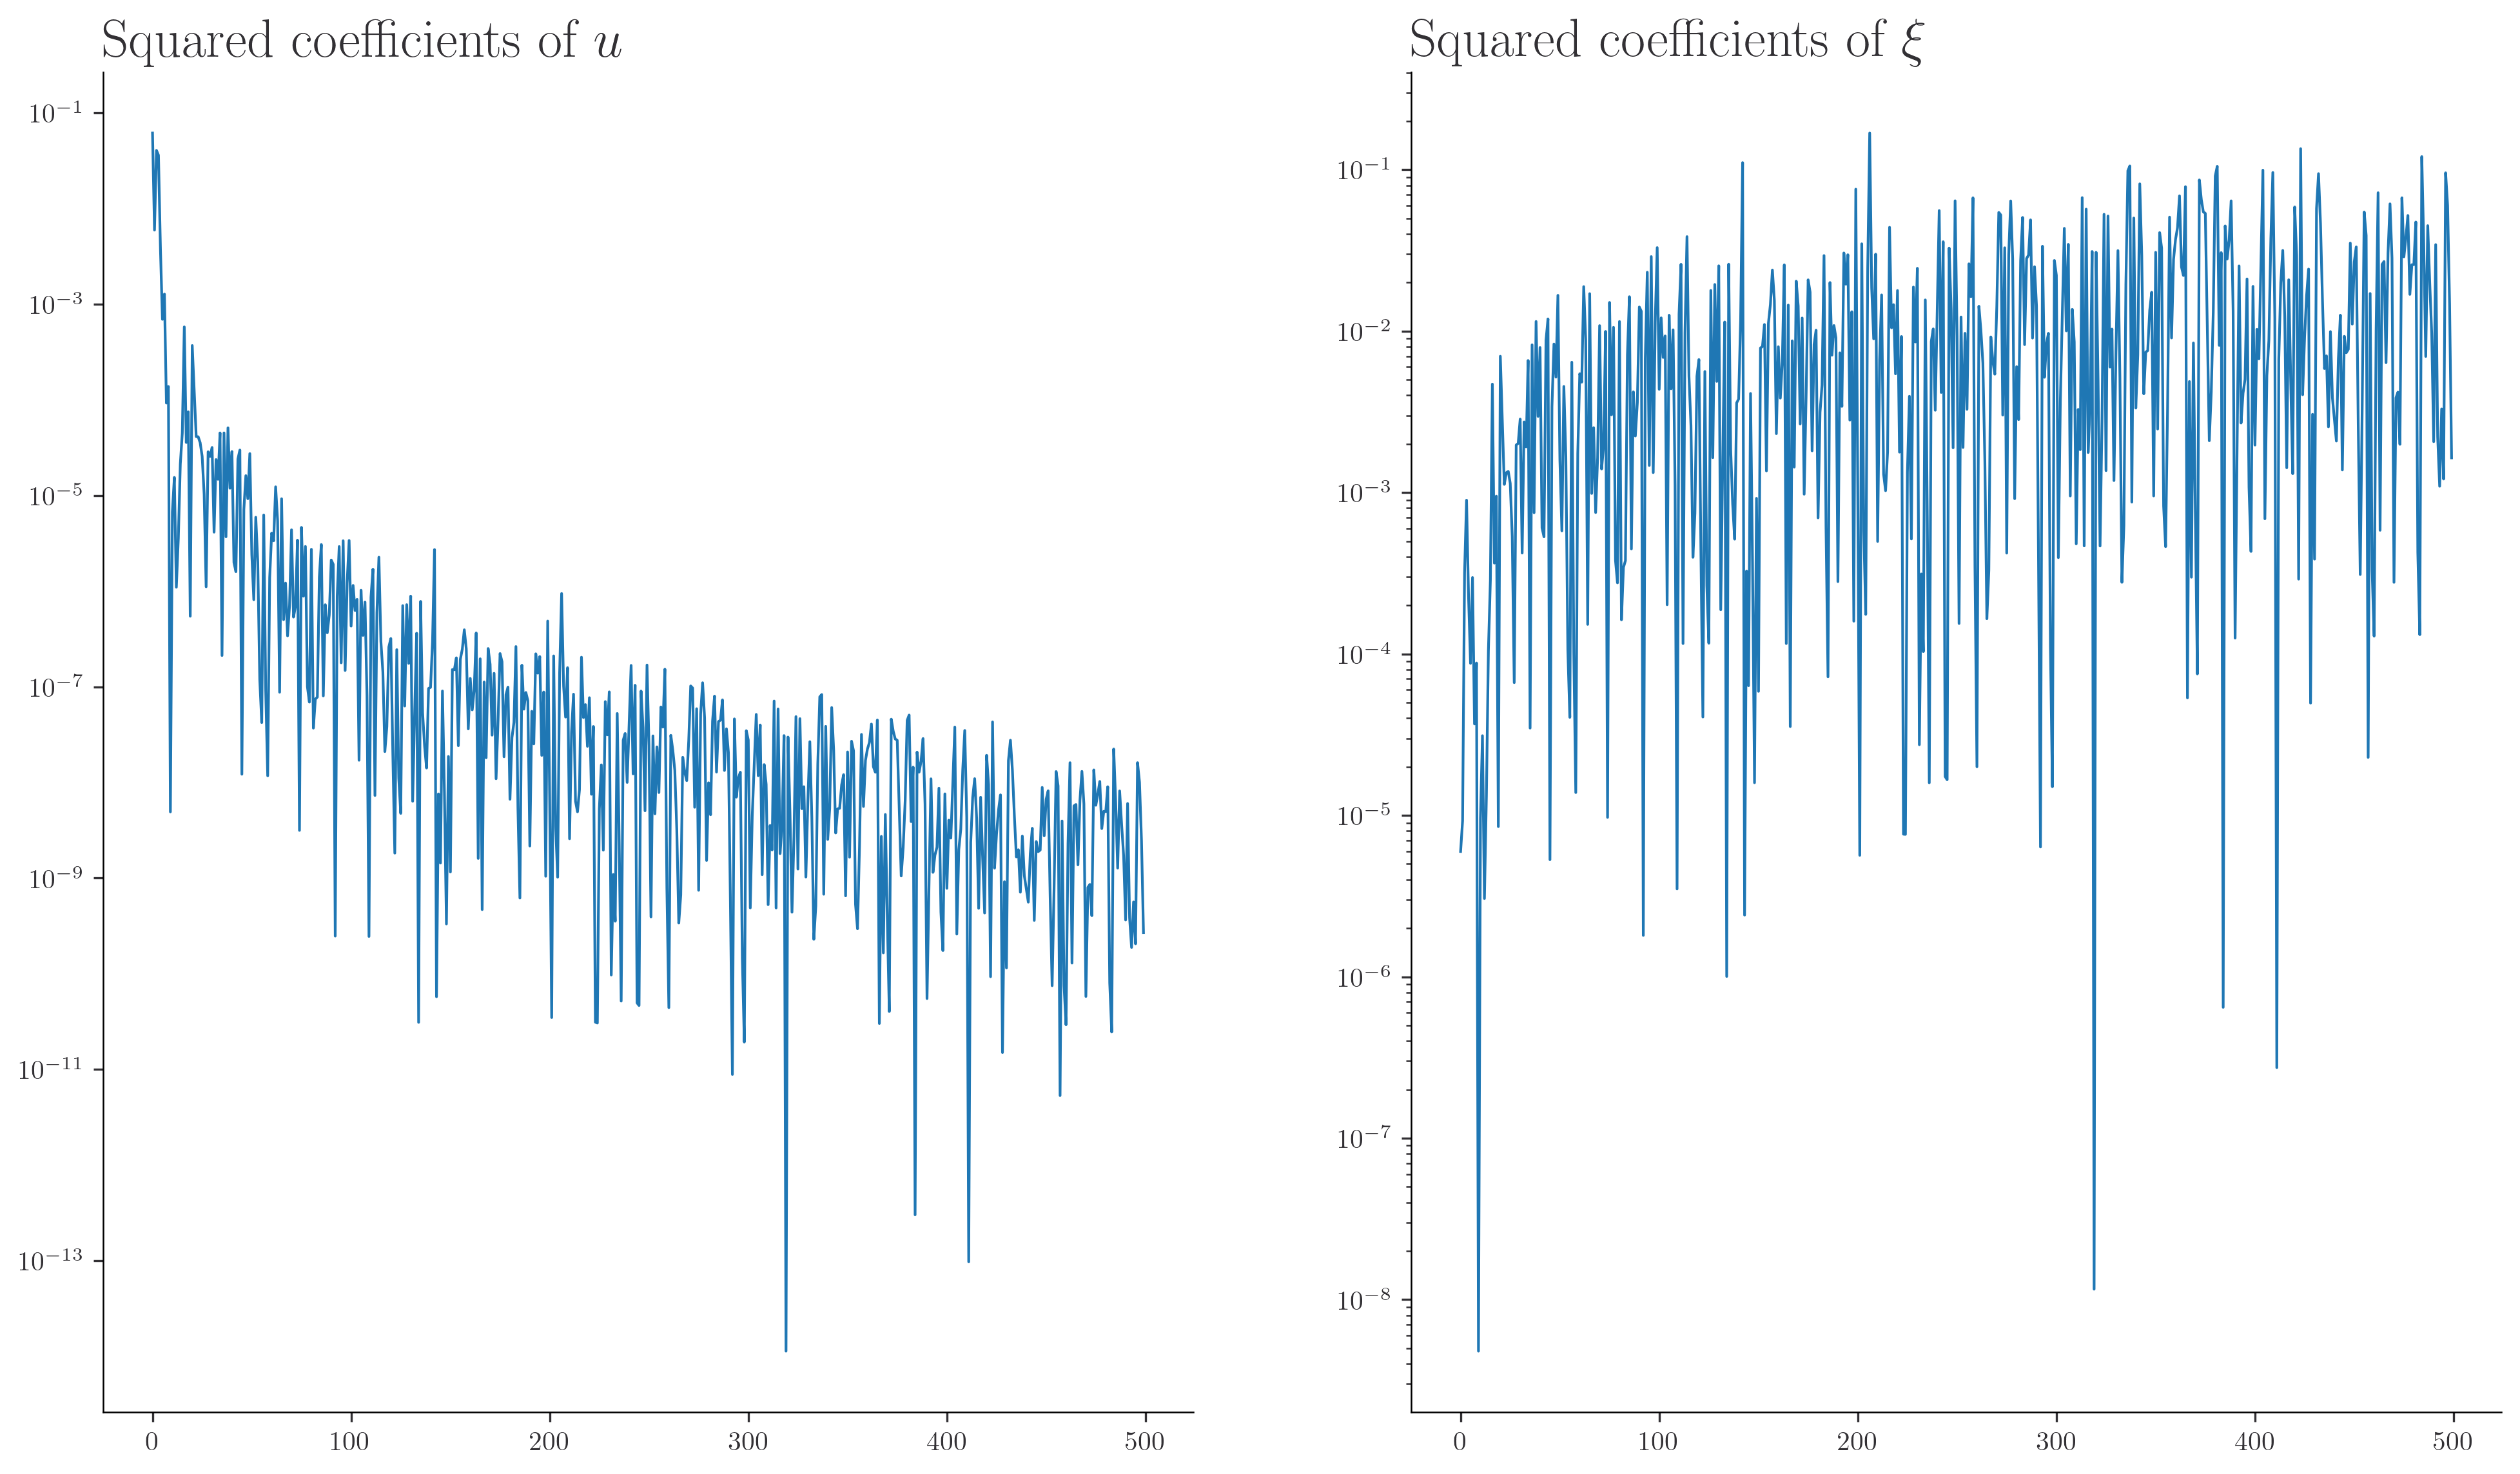

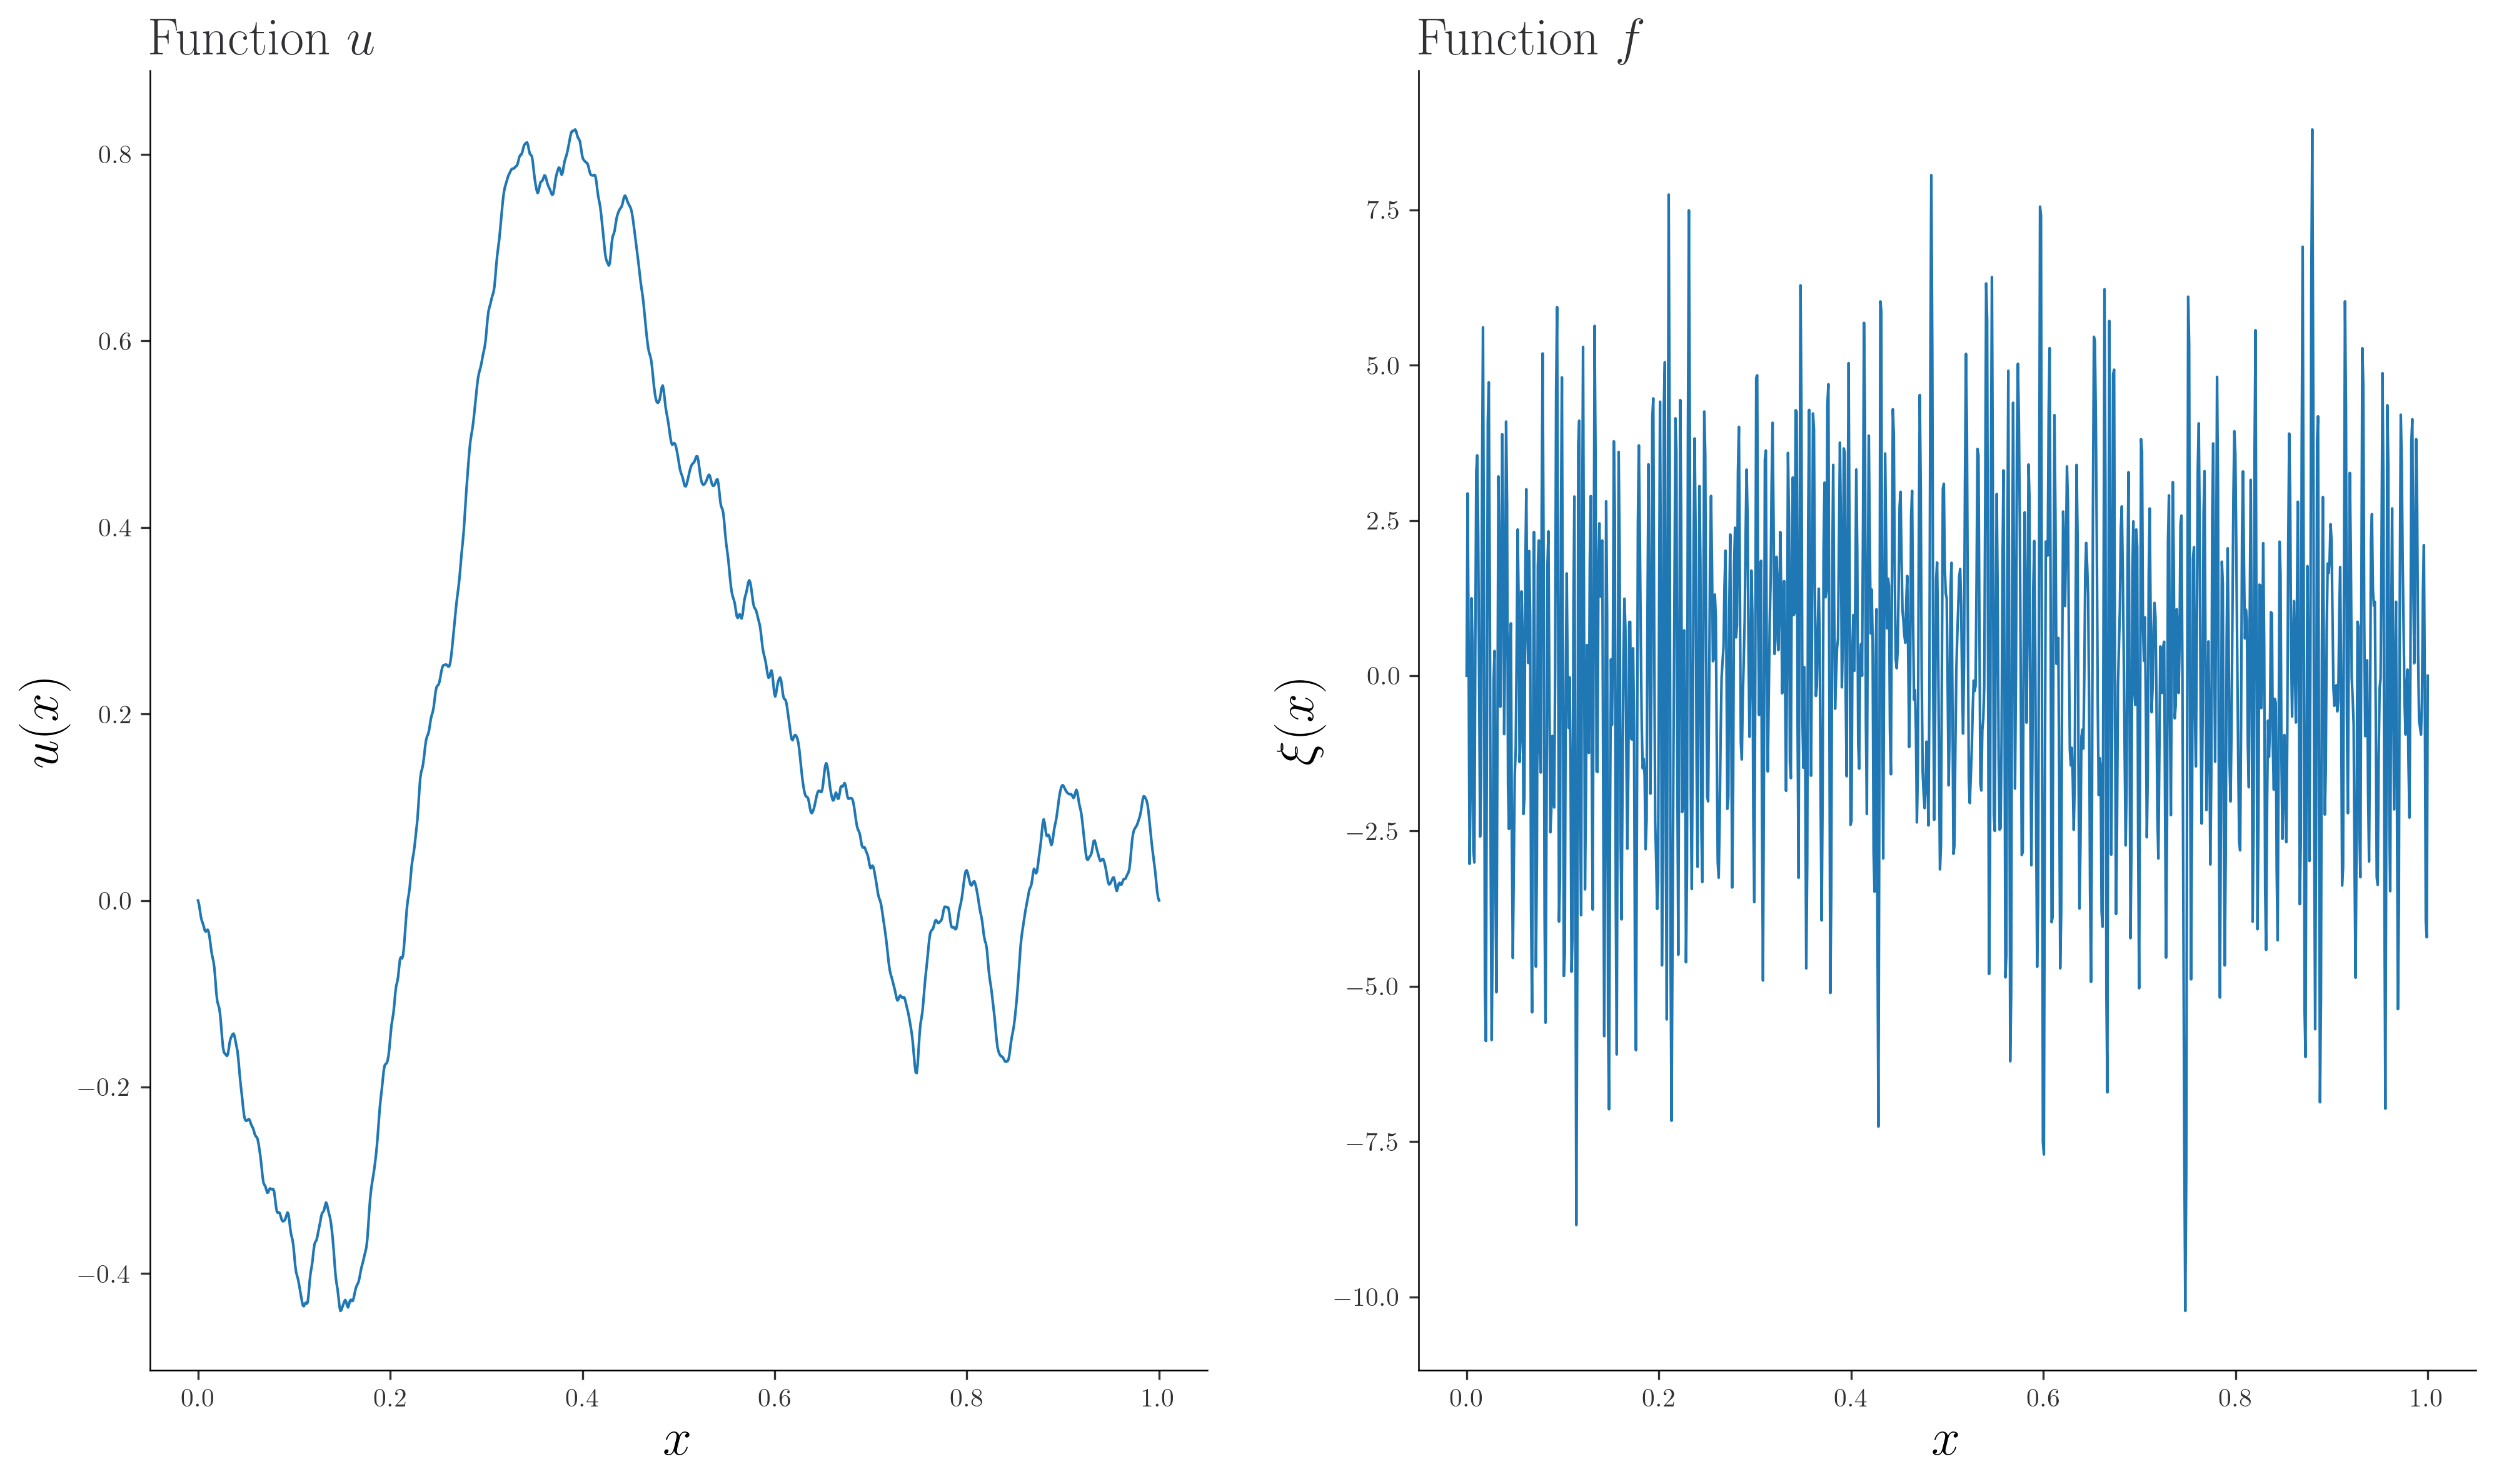

In [147]:
# Create the RHS

nu = 1e-3
b = lambda x: jnp.ones_like(x)  # Coefficinet in front of the u in the PDE (constant here)

# draw random values for the coefficients
#key = random.PRNGKey(54)
key = random.PRNGKey(11)
n_coef = 500

s = 1
alpha = 2*s+1 + 0.1
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f_constant = coef_u*(nu*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2)

#x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f_constant, L=L) + b(x)*u_values

# Plot both the coeffients of u and f in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, height))
ax1.plot(coef_u**2)
ax1.set_yscale('log')
ax1.set_title(r'Squared coefficients of $u$')
ax2.plot(coef_f_constant**2)
ax2.set_yscale('log')
ax2.set_title(r'Squared coefficients of $\xi$')

plt.show()

# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(width, height))
ax[0].plot(x, u_values)
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$u(x)$")
ax[0].set_title(r"Function $u$")

ax[1].plot(x, f_values)
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$\xi(x)$")
ax[1].set_title(r"Function $f$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

# Create measurements: integrate against test function

In [148]:
m_tool = measurement_tool(domain, 500)
root_b = m_tool.evaluate_at_roots(b)

# Create evaluatiolns of u for the error
u_lambda = lambda x: evaluate_function(x, coef_u, L=L)
u_error = m_tool.evaluate_for_error(u_lambda)

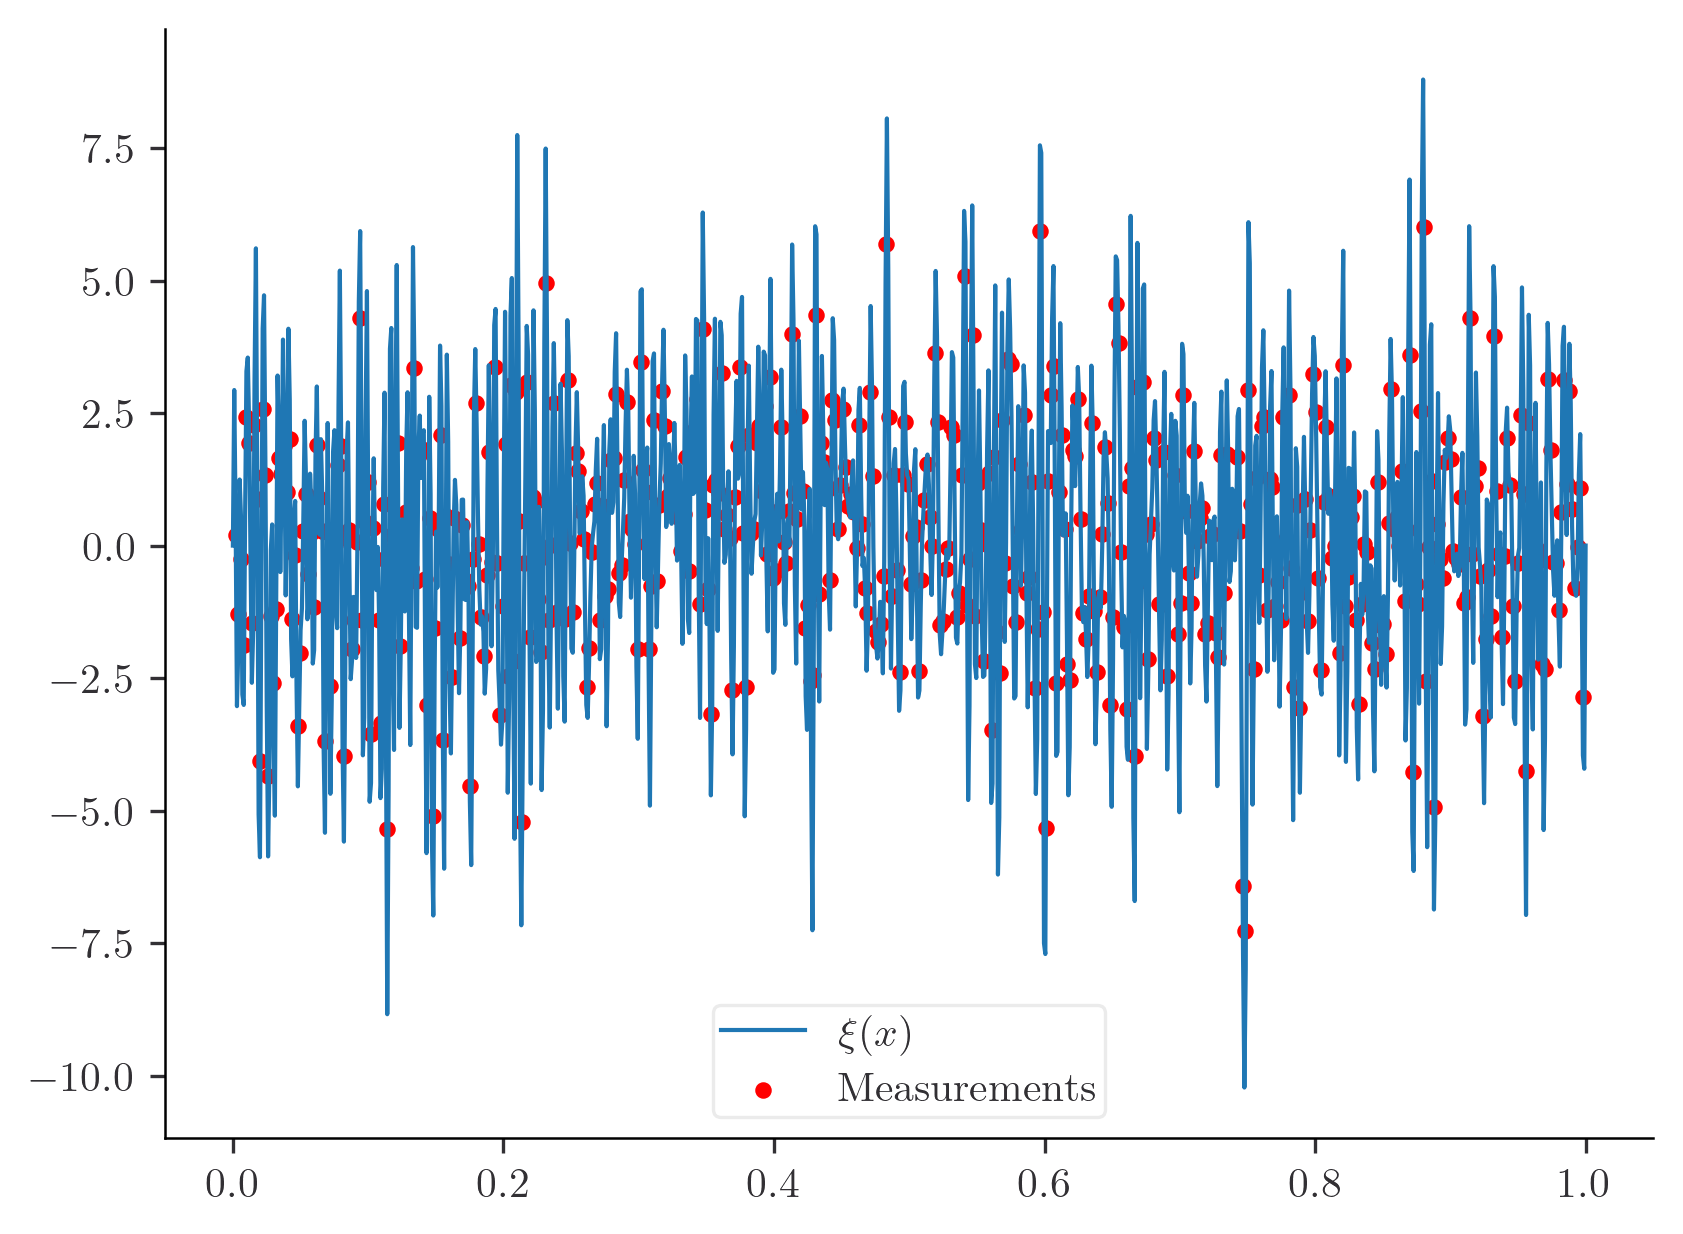

In [149]:
# Project f against the test functions
f_quad = evaluate_function(m_tool.root_psi, coef_f_constant, L) + b(m_tool.root_psi)*evaluate_function(m_tool.root_psi, coef_u, L)
f_meas = m_tool.project(f_quad)

plt.plot(x, f_values, label = r'$\xi(x)$')
plt.scatter(m_tool.centers, f_meas, color='r', s = 10, label = 'Measurements')
plt.legend()
plt.show()

# Solving the linear problem

### Regularized

In [150]:
from utils_optim import kernel_linear_solver

In [151]:
# Regularized linear solver
reg = 1e-8
length_scale = 0.1

solver = kernel_linear_solver(length_scale, m_tool.psi_matrix, m_tool.root_psi, boundary, boundary_conditions, nu)
solver.solve_linear_prob(f_meas, reg, root_b, m_tool.L_stiff)

l_2_error, l_2_rel, h_s_error, h_s_rel = solver.residuals
loss, relative_loss = solver.compute_error(m_tool.x_error, m_tool.w_error, u_error)

print("L2 error: ", loss)
print("L2 relative error: ", relative_loss)

pred = solver.evaluate_solution(x)

L2 error:  0.004273255454268286
L2 relative error:  0.011024759330098695


In [152]:
# 4:3 aspect ratio
width = 4
height = width * 3 / 4


In [153]:
plt.style.use('plot_style-Examples.txt')

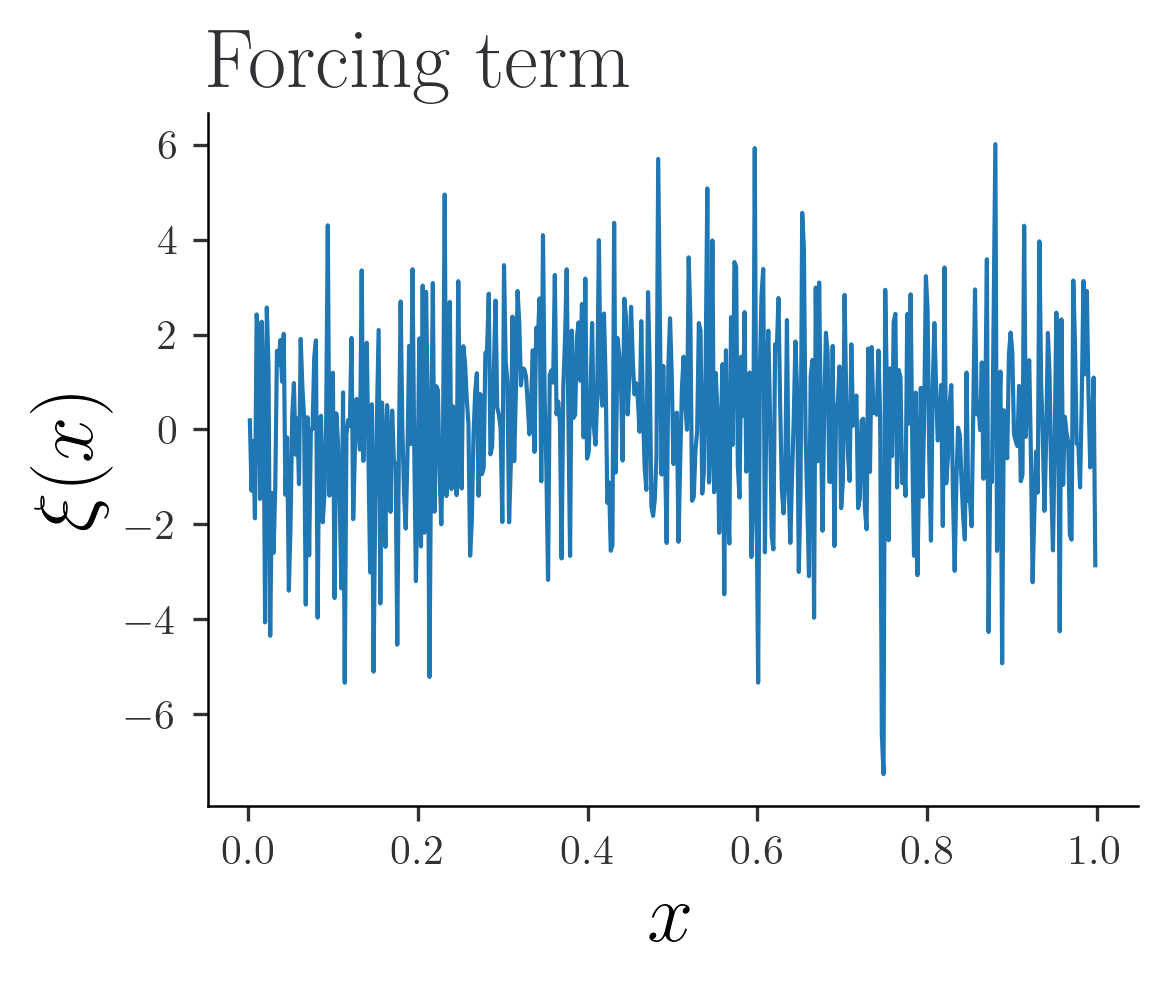

In [154]:
figure = plt.figure(figsize=(width, height))
plt.plot(m_tool.centers, f_meas)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Forcing term")
plt.savefig('figures/elliptic/forcing_term.png', bbox_inches = 'tight')
plt.show()


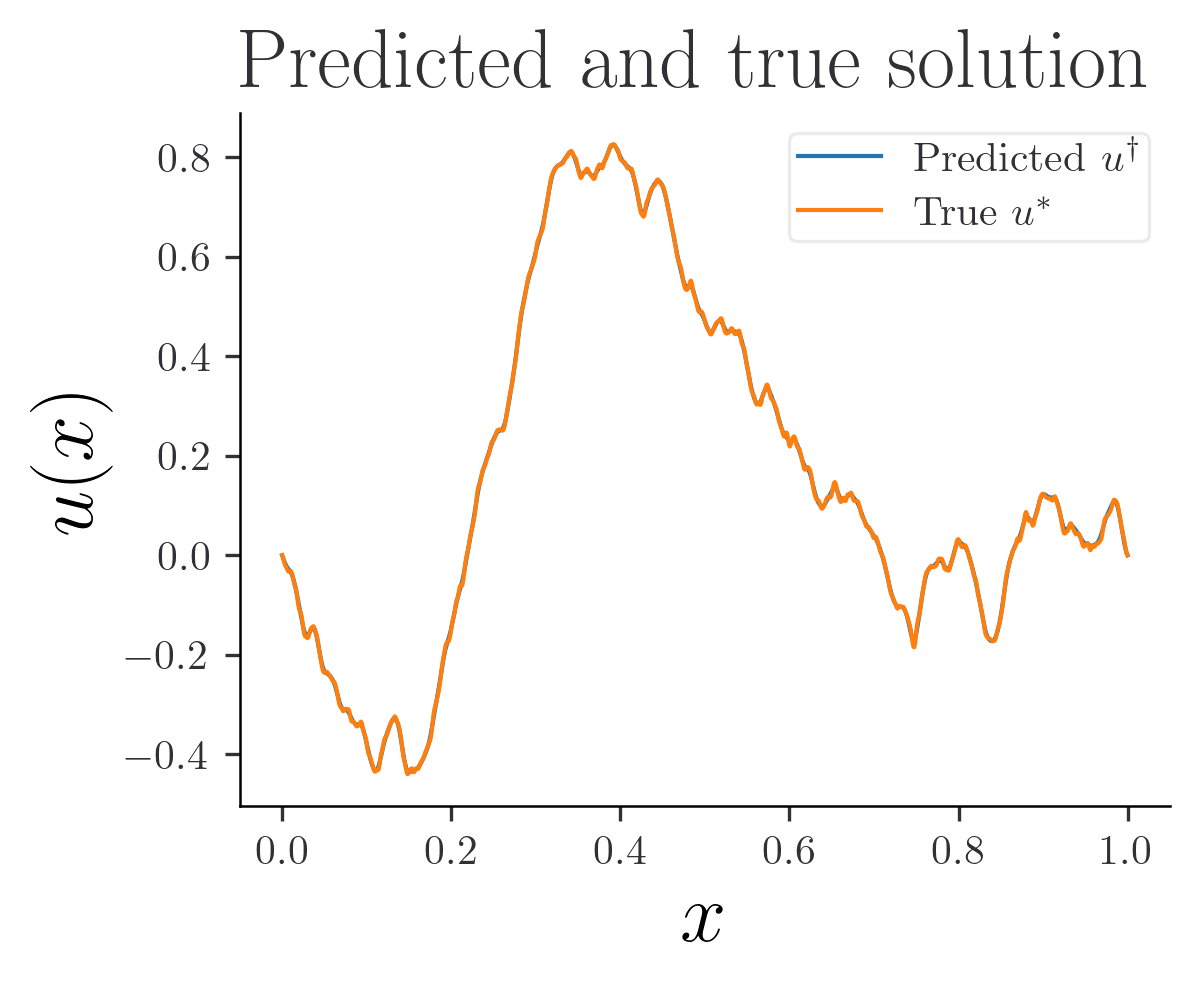

In [155]:
figure = plt.figure(figsize=(width, height))
plt.plot(x, pred, label = 'Predicted $u^\dagger$')
plt.plot(x, u_values, label = r'True $u^*$')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Predicted and true solution")
plt.legend()
plt.savefig('figures/elliptic/prediction_solution_semilinear.png', bbox_inches = 'tight')
plt.show()


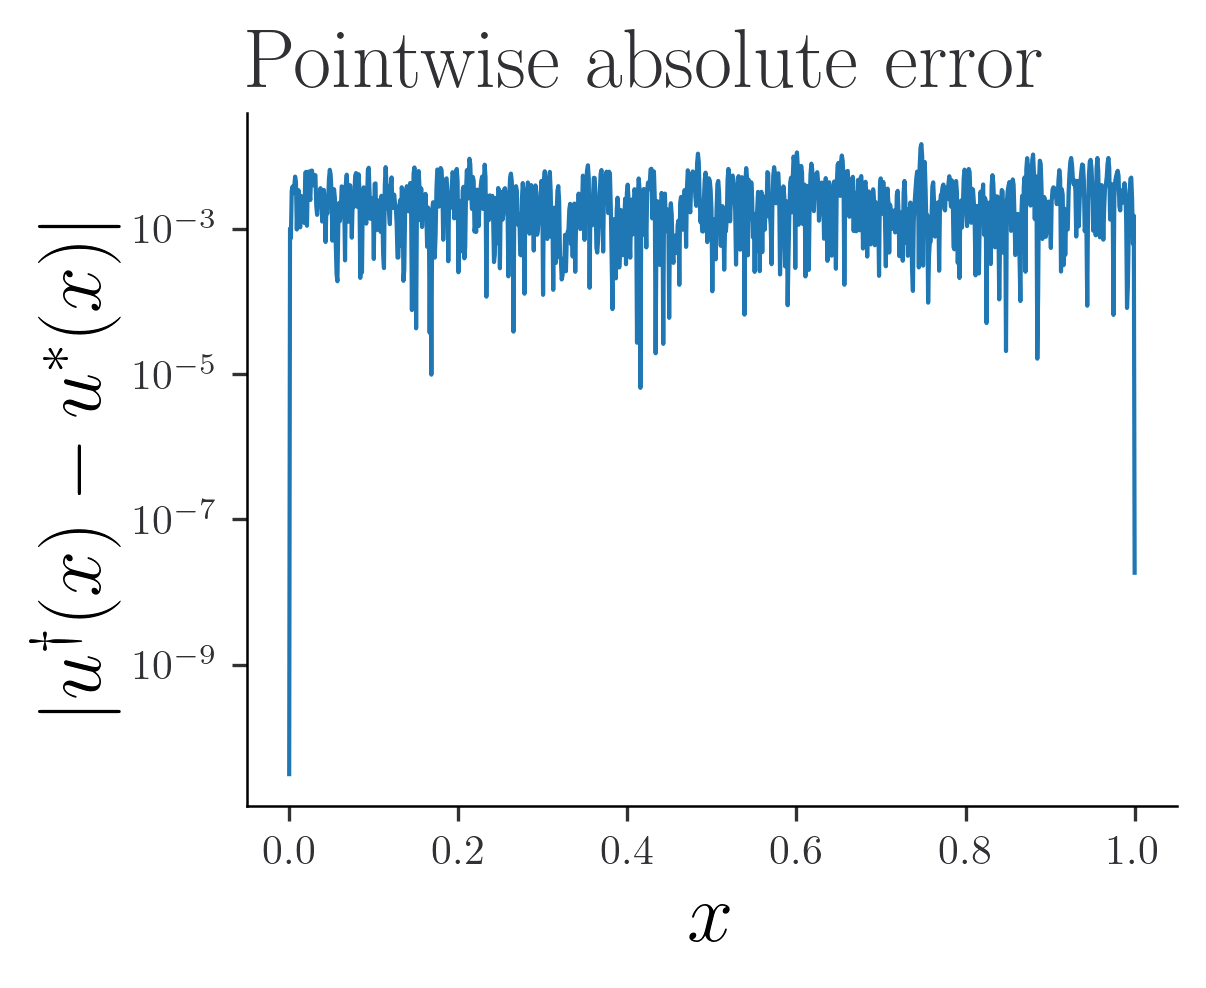

In [156]:
figure = plt.figure(figsize=(width, height))
plt.plot(x, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.savefig('figures/elliptic/pointwise_error.png', bbox_inches = 'tight')
plt.show()


In [157]:
# # Plot
# fig, ax = plt.subplots(4, figsize=(15, 10))

# ax[0,0].plot(x, pred, color = "red", label = "Prediction")
# ax[0,0].plot(x, u_values, color = "blue", label = "True")
# ax[0,0].set_title("Prediction vs True")
# ax[0,0].legend()

# ax[0,1].plot(x, pred - u_values, label = "Error")
# ax[0,1].set_title("Pointwise error")
# ax[0,1].set_yscale('log')

# ax[1,0].plot(m_tool.centers, f_meas, label = "True")
# ax[1,0].plot(m_tool.centers, solver.meas, label = "Prediction")
# ax[1,0].set_title("Measurements")
# ax[1,0].legend()

# ax[1,1].plot(m_tool.centers, solver.meas - f_meas)
# ax[1,1].set_title("Measurement error")
# ax[1,1].set_yscale('log')

# plt.show()

### Unregularized

In [158]:
# Regularized linear solver
reg = None
length_scale = 0.1

solver = kernel_linear_solver(length_scale, m_tool.psi_matrix, m_tool.root_psi, boundary, boundary_conditions, nu)
solver.solve_linear_prob(f_meas, reg, root_b, m_tool.L_stiff)

l_2_error, l_2_rel, h_s_error, h_s_rel = solver.residuals
loss, relative_loss = solver.compute_error(m_tool.x_error, m_tool.w_error, u_error)

print("L2 error: ", loss)
print("L2 relative error: ", relative_loss)

pred = solver.evaluate_solution(x)


L2 error:  0.0003307906706721742
L2 relative error:  0.0008534213720268023


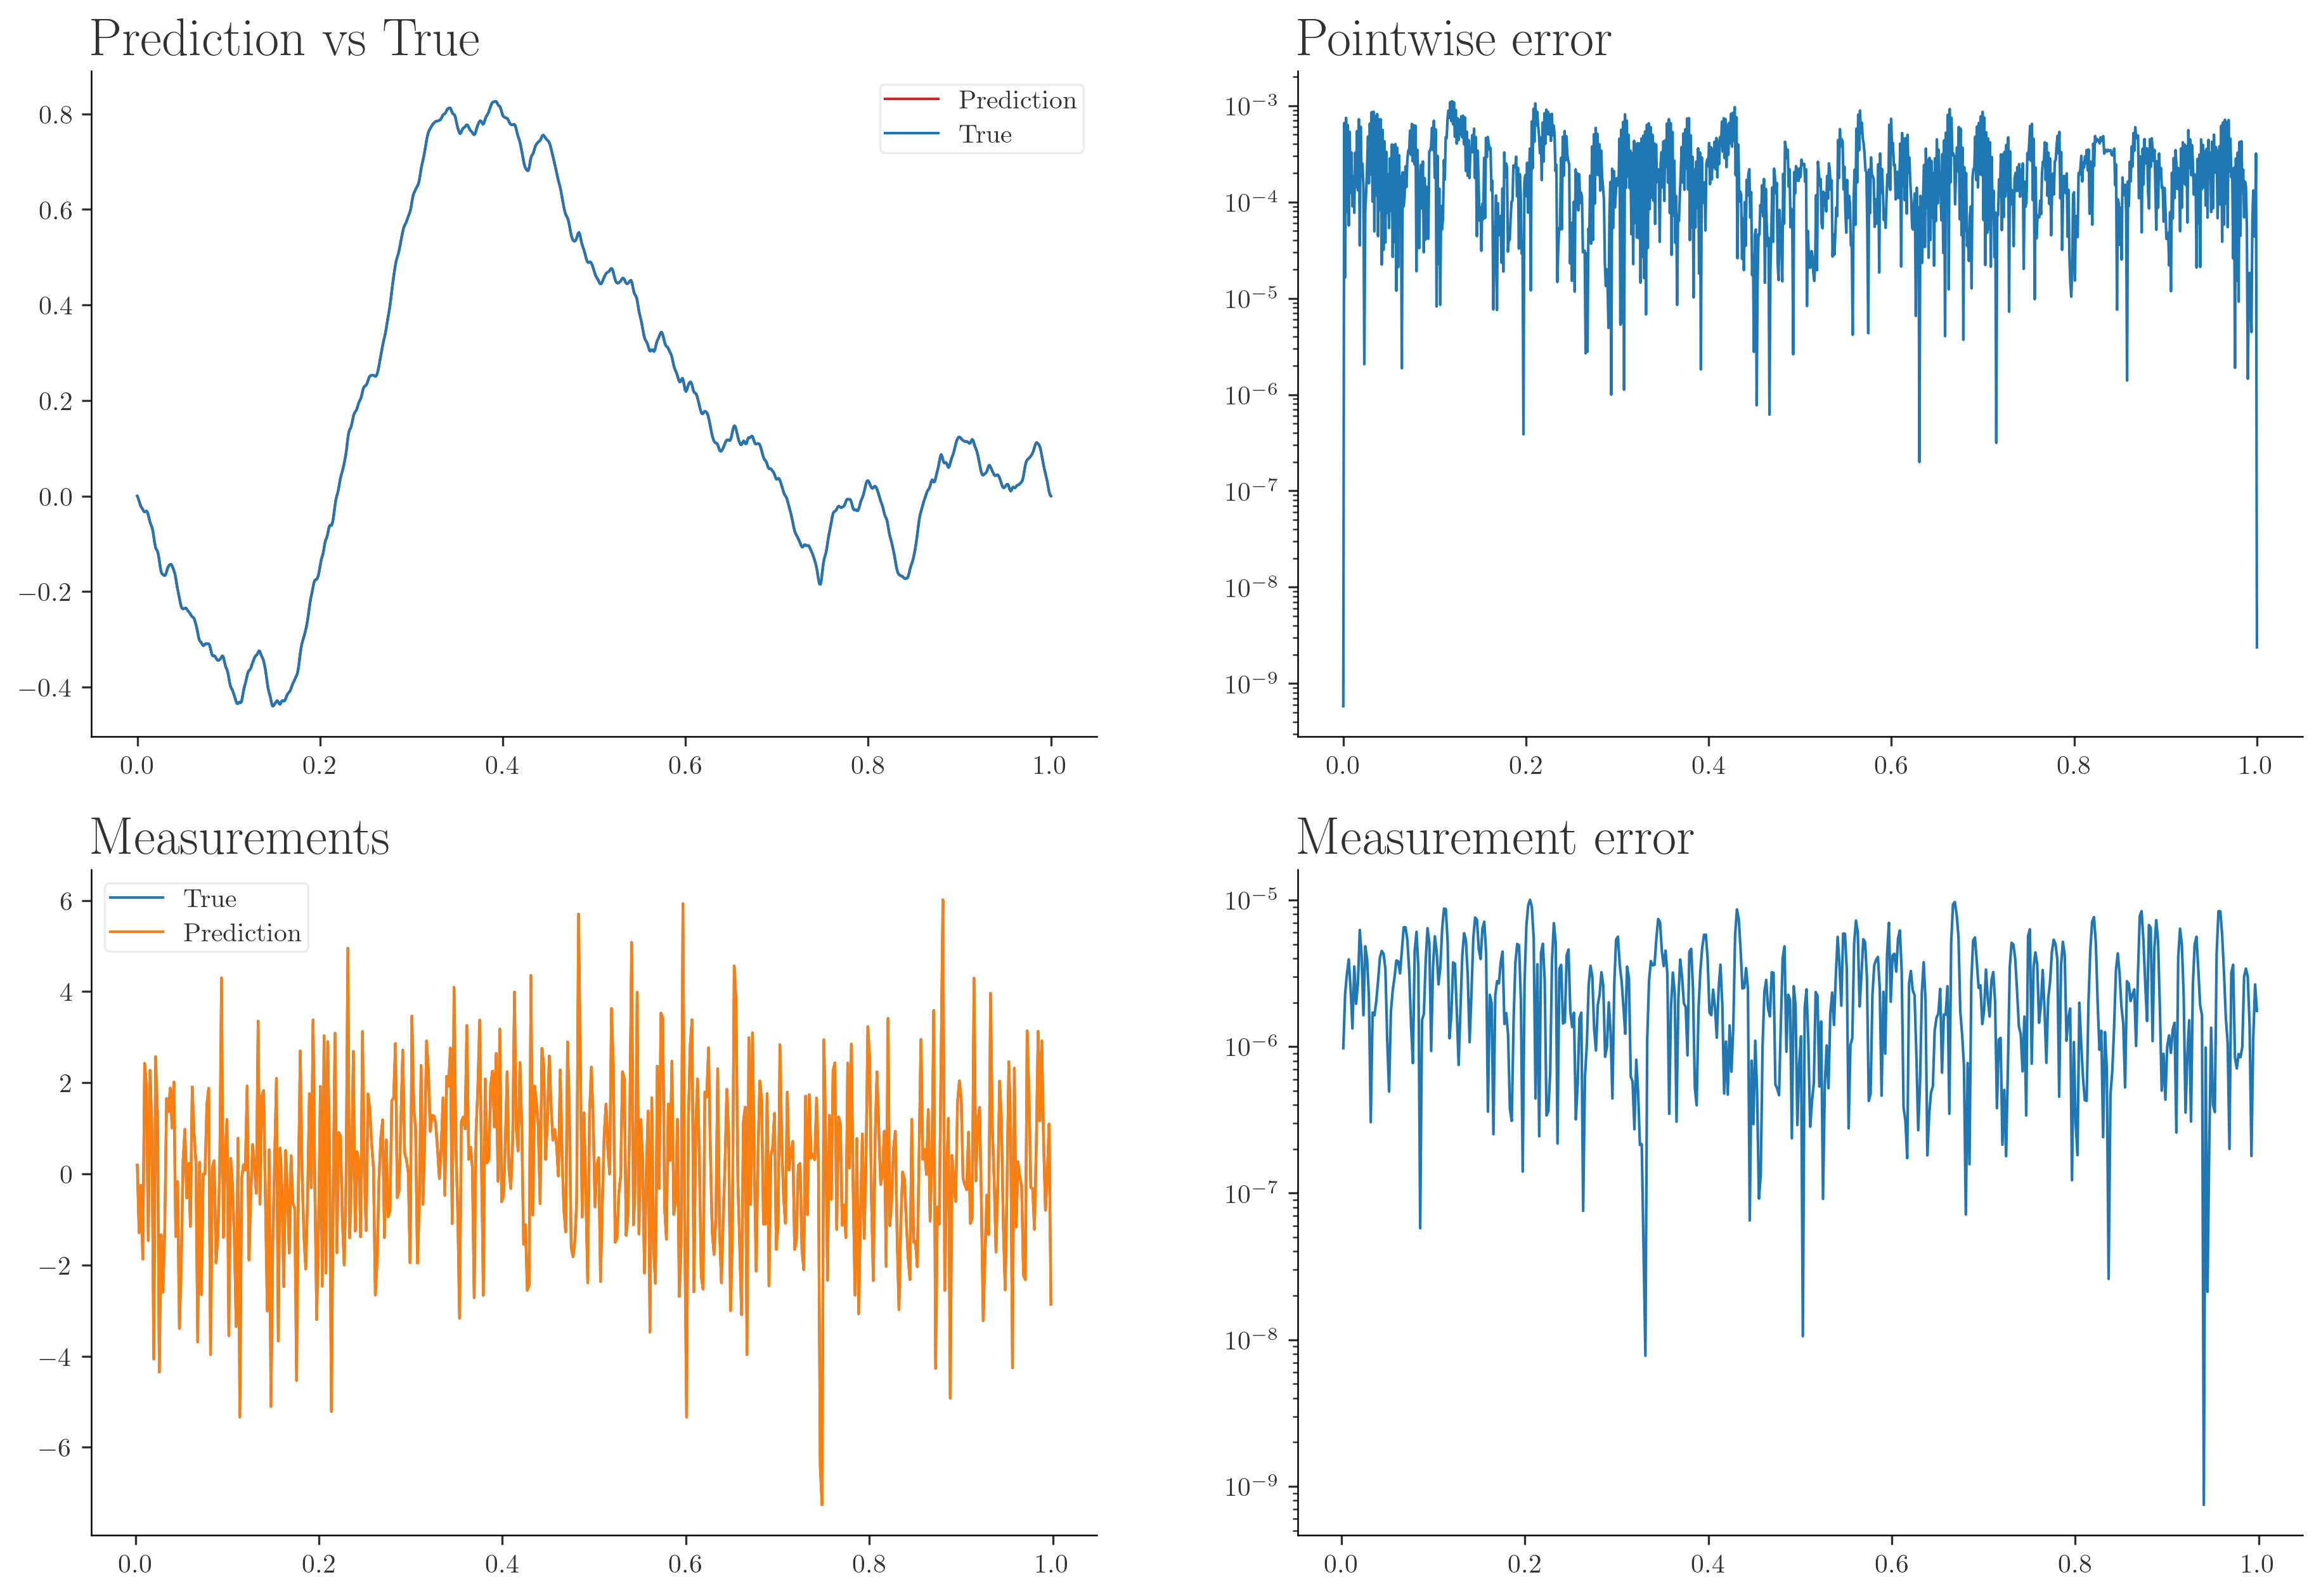

In [159]:
# Plot
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0,0].plot(x, pred, color = "tab:red", label = "Prediction")
ax[0,0].plot(x, u_values, color = "tab:blue", label = "True")
ax[0,0].set_title("Prediction vs True")
ax[0,0].legend()

ax[0,1].plot(x, jnp.abs(pred - u_values), label = "Error")
ax[0,1].set_title("Pointwise error")
ax[0,1].set_yscale('log')

ax[1,0].plot(m_tool.centers, f_meas, label = "True")
ax[1,0].plot(m_tool.centers, solver.meas, label = "Prediction")
ax[1,0].set_title("Measurements")
ax[1,0].legend()

ax[1,1].plot(m_tool.centers, jnp.abs(solver.meas - f_meas))
ax[1,1].set_title("Measurement error")
ax[1,1].set_yscale('log')

plt.show()

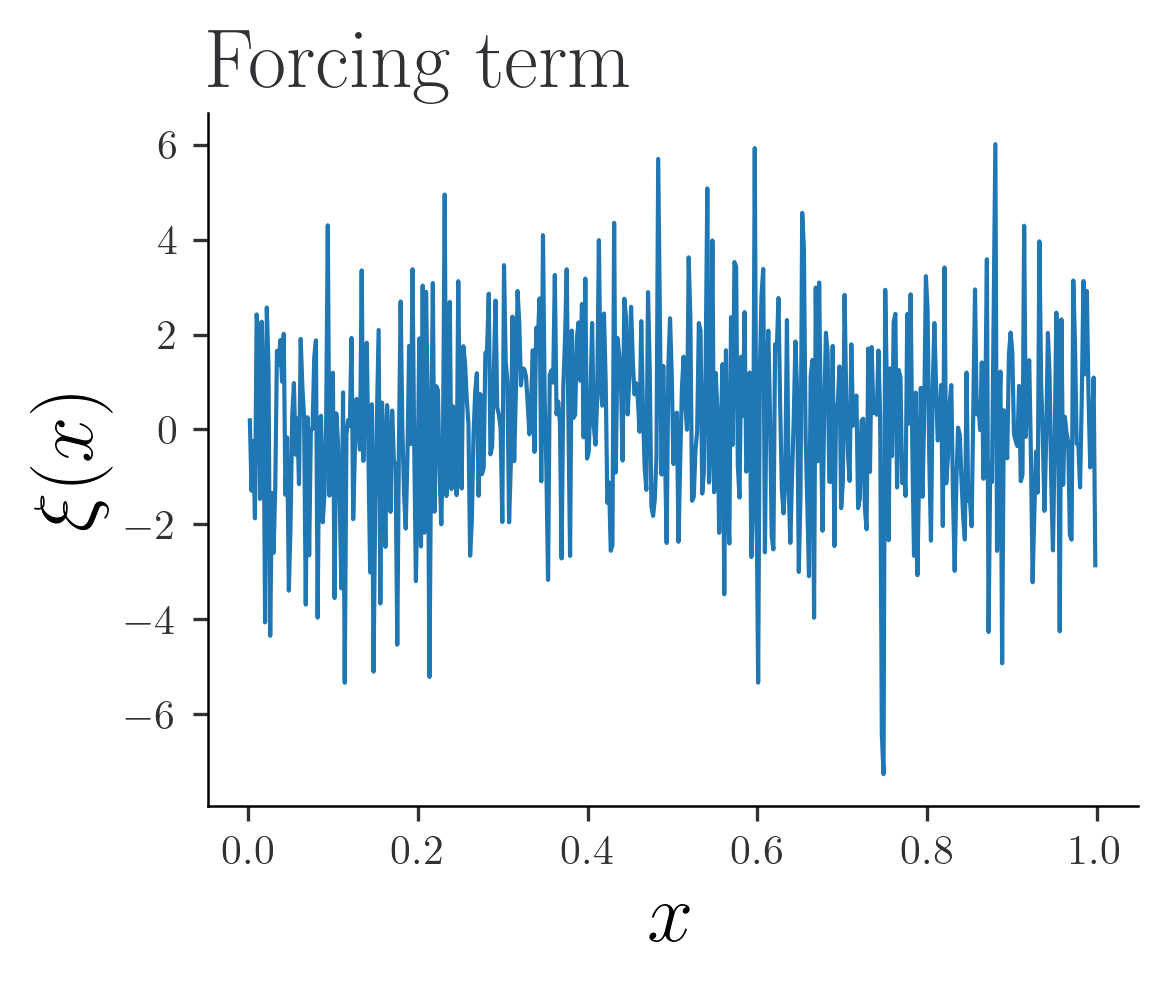

In [160]:
figure = plt.figure(figsize=(width, height))
plt.plot(m_tool.centers, f_meas, color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Forcing term")
plt.savefig('figures/elliptic/forcing_term.png', bbox_inches = 'tight')
plt.show()


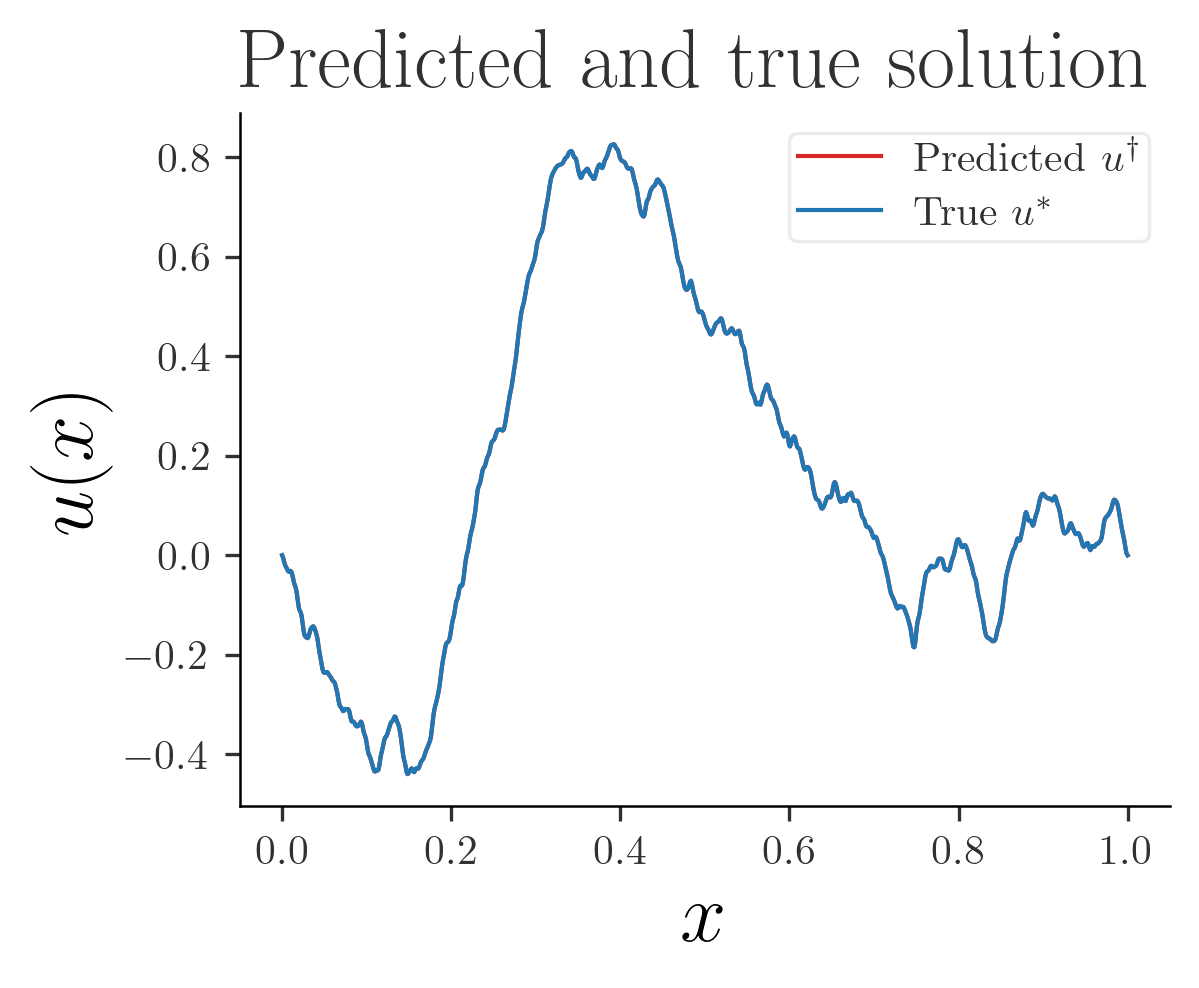

In [161]:
figure = plt.figure(figsize=(width, height))
plt.plot(x, pred, label = 'Predicted $u^\dagger$', color = 'tab:red')
plt.plot(x, u_values, label = r'True $u^*$', color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Predicted and true solution")
plt.legend()
plt.savefig('figures/elliptic/prediction_solution_semilinear.png', bbox_inches = 'tight')
plt.show()


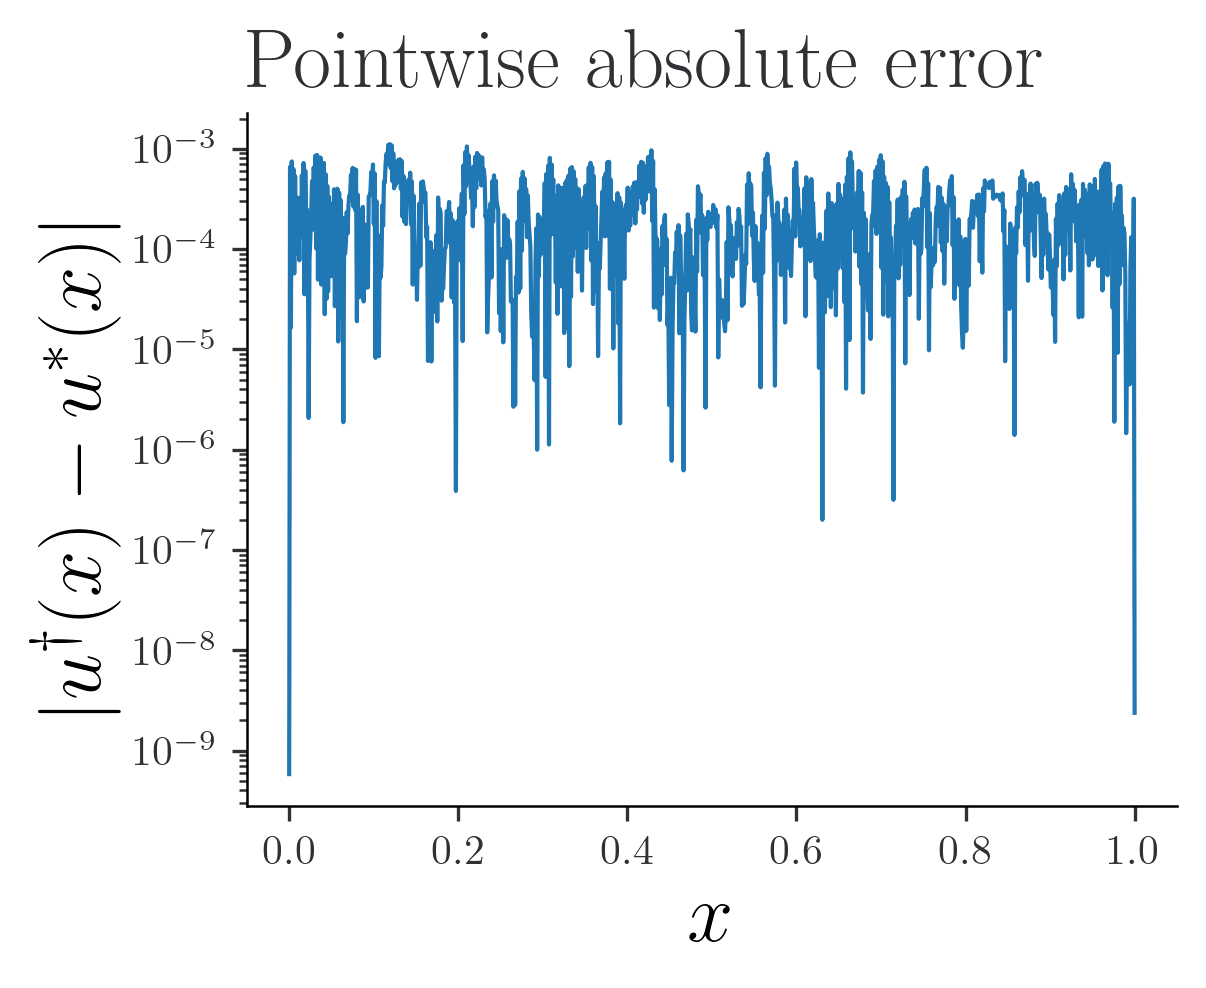

In [162]:
figure = plt.figure(figsize=(width, height))
plt.plot(x, jnp.abs(pred - u_values), color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.savefig('figures/elliptic/pointwise_error.png', bbox_inches = 'tight')
plt.show()


# Computing error rates

In [89]:
meas_exp = jnp.arange(4, 11)

error = []
error_rel = []
for i in tqdm(meas_exp):
    n_meas = 2**i
    m_tool = measurement_tool(domain, n_meas)
    root_b = m_tool.evaluate_at_roots(b)

    # Project f against the test functions
    f_quad = evaluate_function(m_tool.root_psi, coef_f_constant, L) + b(m_tool.root_psi)*evaluate_function(m_tool.root_psi, coef_u, L)
    f_meas = m_tool.project(f_quad)

    # Solve the linear problem
    solver = kernel_linear_solver(length_scale, m_tool.psi_matrix, m_tool.root_psi, boundary, boundary_conditions, nu)
    solver.solve_linear_prob(f_meas, reg, root_b, m_tool.L_stiff)

    loss, relative_loss = solver.compute_error(m_tool.x_error, m_tool.w_error, u_error)
    error.append(loss)
    error_rel.append(relative_loss)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:36<00:00,  5.15s/it]


In [91]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b = log_error
r, C = jnp.linalg.lstsq(a, b)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 



L^2 Convergence rate:  2.712


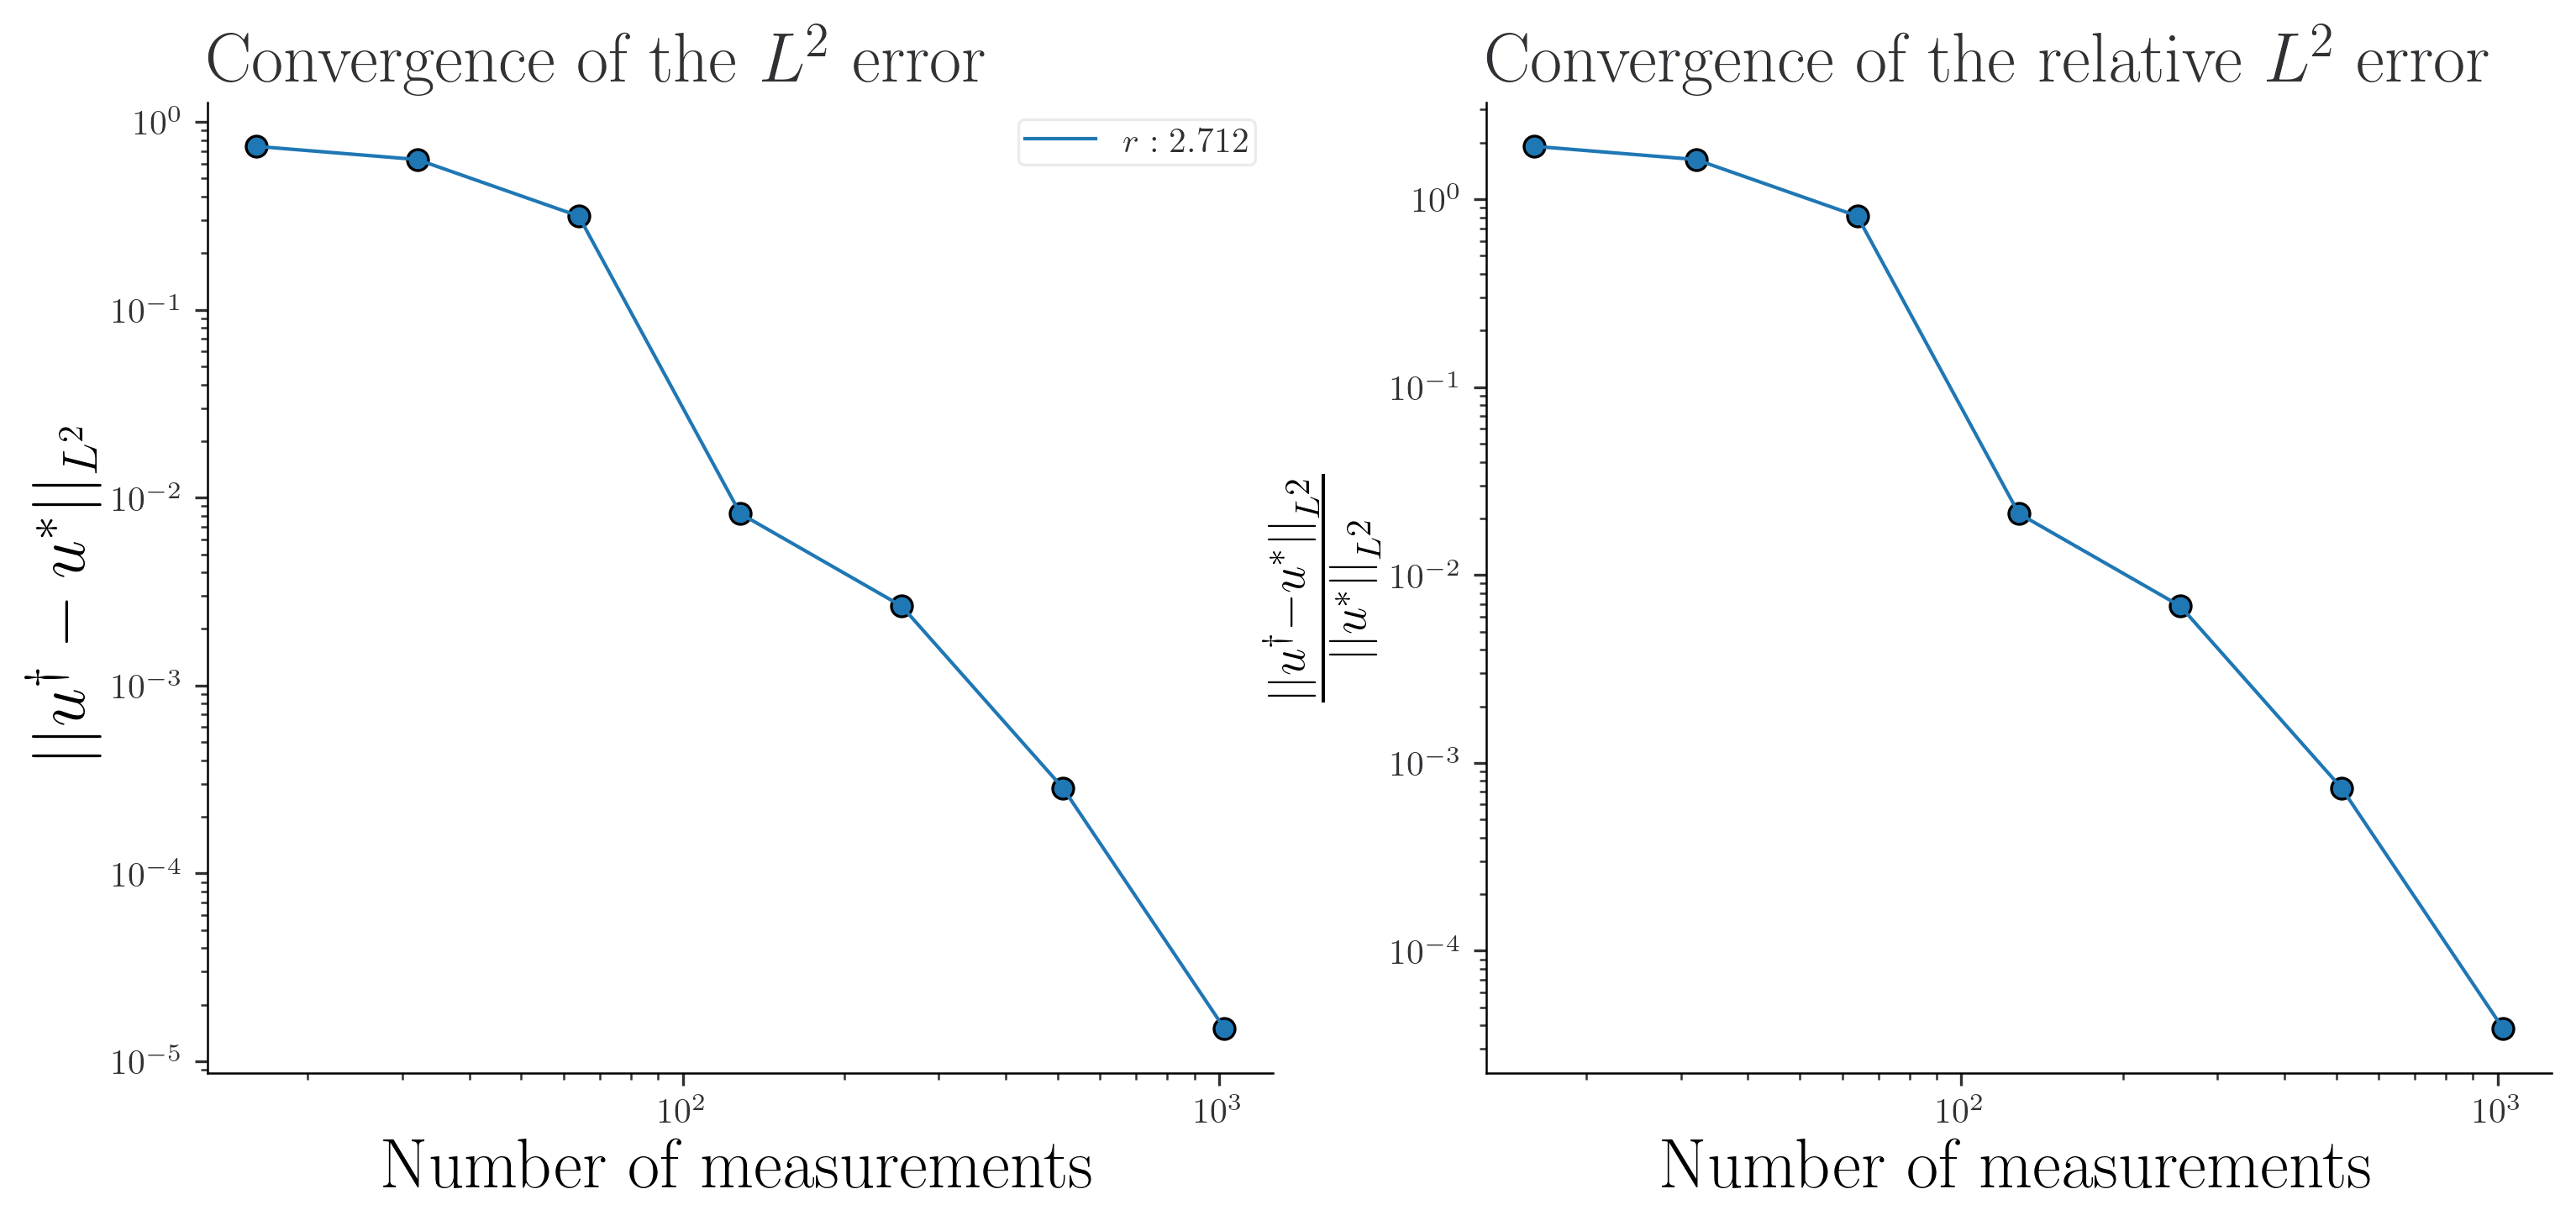

In [99]:
# Plot the convergence rates 

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
ax[0].scatter(2**meas_exp, error)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("Number of measurements")
ax[0].set_ylabel(r"$||u^\dagger - u^*||_{L^2}$")
ax[0].set_title(r"Convergence of the $L^2$ error")
ax[0].legend()

ax[1].plot(2**meas_exp, error_rel, label = r"$r :{:.03f}$".format(r))
ax[1].scatter(2**meas_exp, error_rel)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("Number of measurements")
ax[1].set_title(r"Convergence of the relative $L^2$ error")
ax[1].set_ylabel(r"$\frac{||u^\dagger - u^*||_{L^2}}{||u^*||_{L^2}}$")

plt.show()

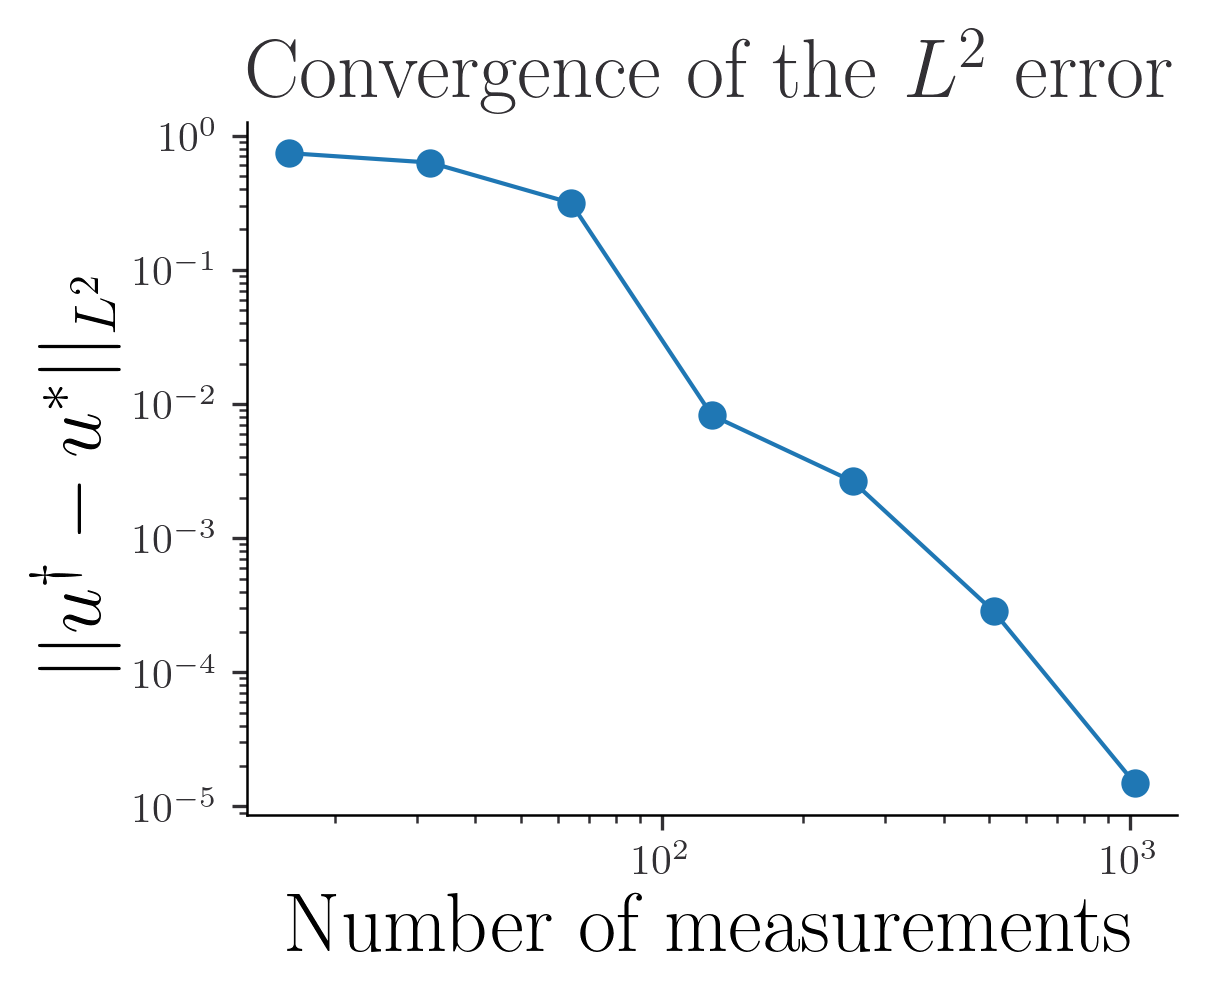

In [100]:
figure = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r), color = 'tab:blue')
plt.scatter(2**meas_exp, error, color = 'tab:blue')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.savefig('figures/elliptic/error_rates.png', bbox_inches = 'tight')
plt.show()


# Semilinear elliptic PDE
We will solve
\begin{aligned}
 -\nu \Delta u +u + u^3 &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

In [163]:
tau = lambda x : x**3
# We hardcode the derivative of tau (one could use autograd to compute it)
tau_prime = lambda x : 3*x**2
b = lambda x: jnp.ones_like(x)

3.1


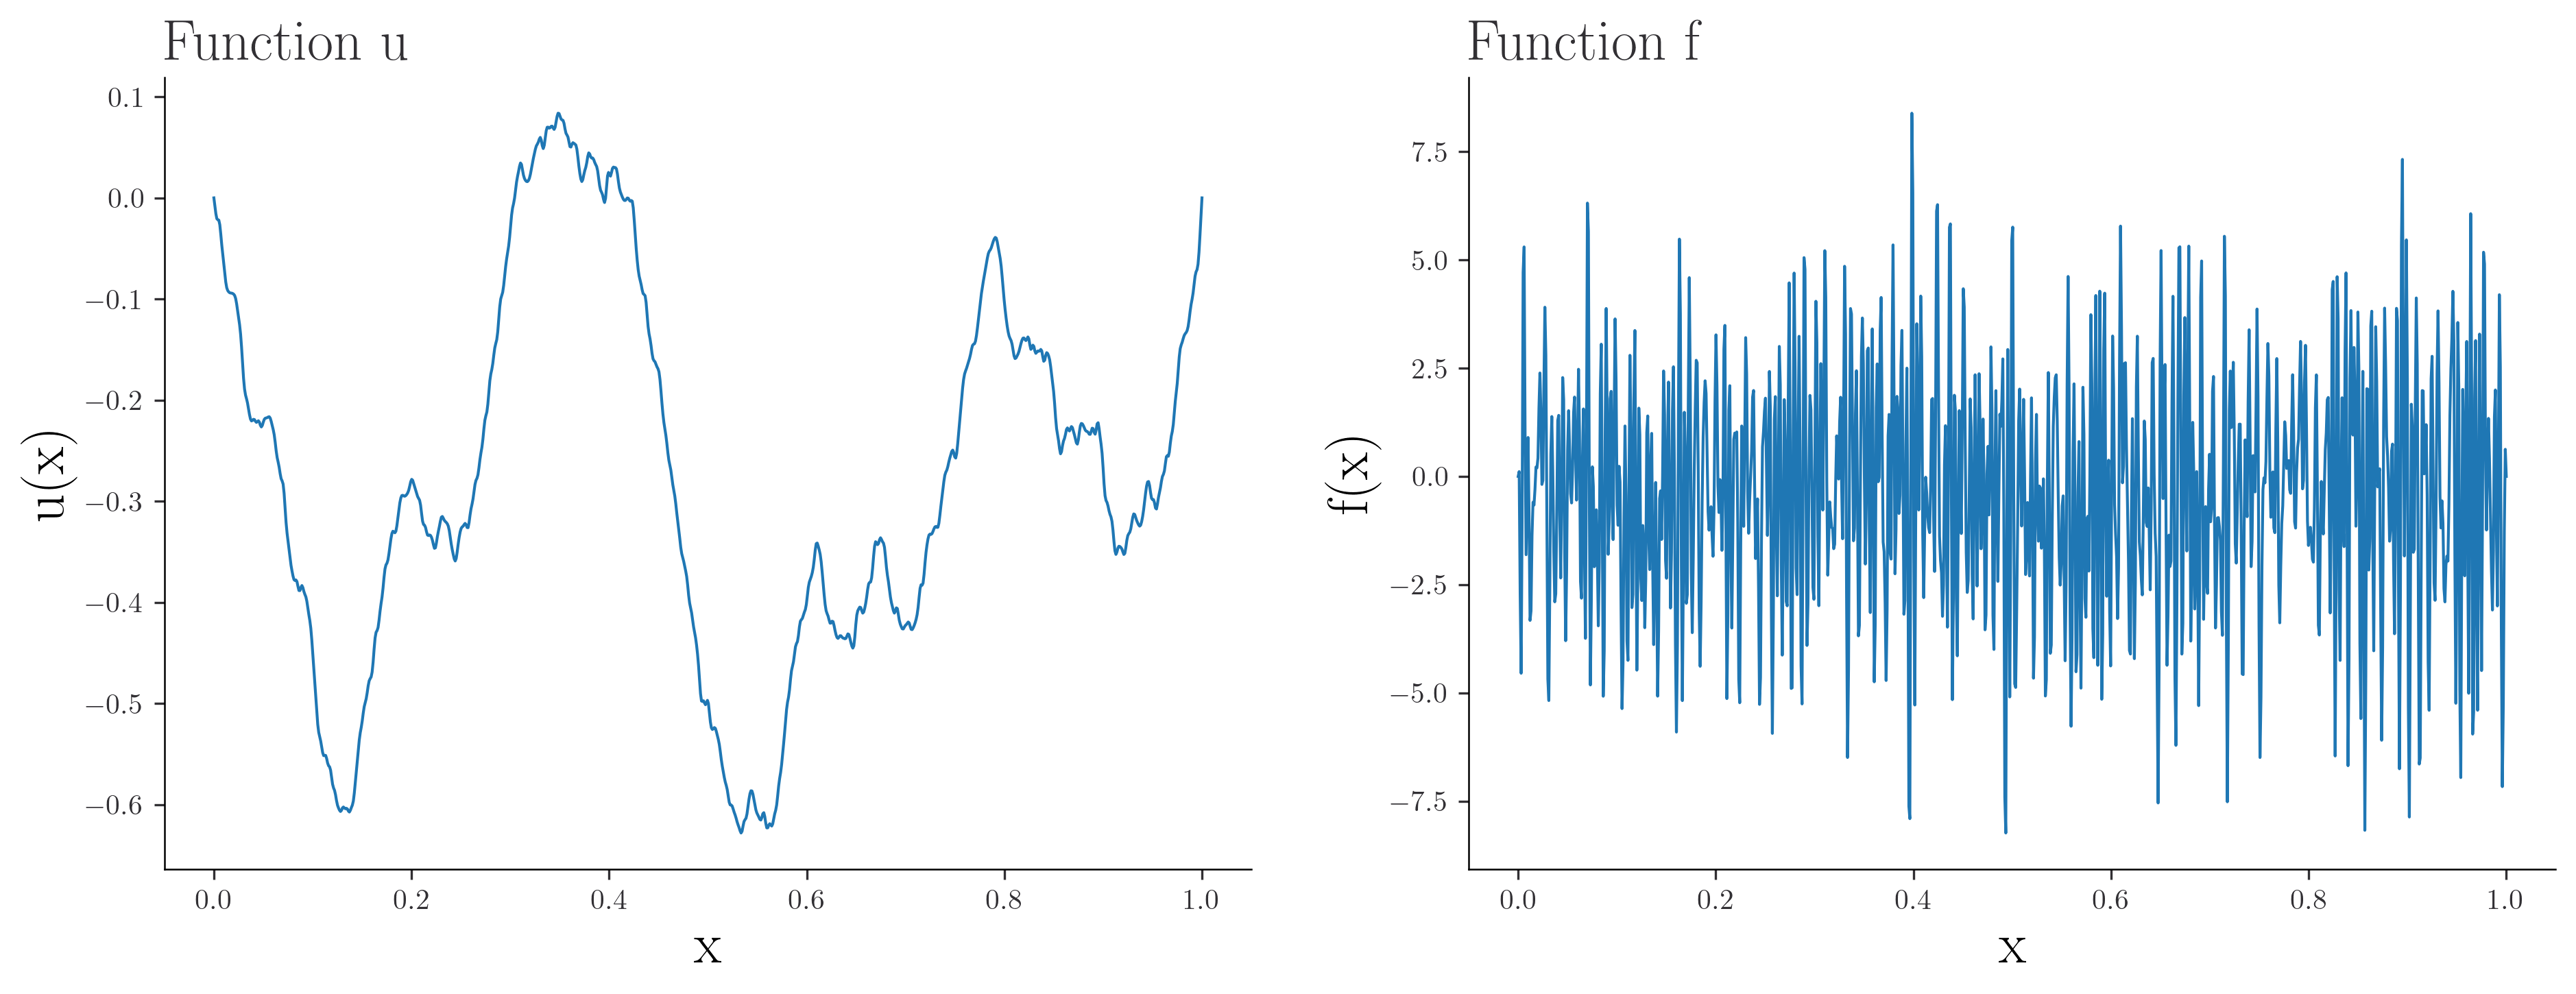

In [164]:
# Create the a semilinear elliptic PDE

nu = 1e-3
# draw random values for the coefficients
n_coef = 500
s = 1
alpha = 2*s+1 + 0.1
print(alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

key, subkey = random.split(key)
coef_u = random.normal(subkey, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f_linear = coef_u*(nu*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2)

#x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f_linear, L=L) + b(x)*u_values + tau(u_values)


# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")

plt.show()

In [165]:
m_tool = measurement_tool(domain, 500)
root_b = m_tool.evaluate_at_roots(b)
u_lambda = lambda x: evaluate_function(x, coef_u, L=L)
u_error = m_tool.evaluate_for_error(u_lambda)

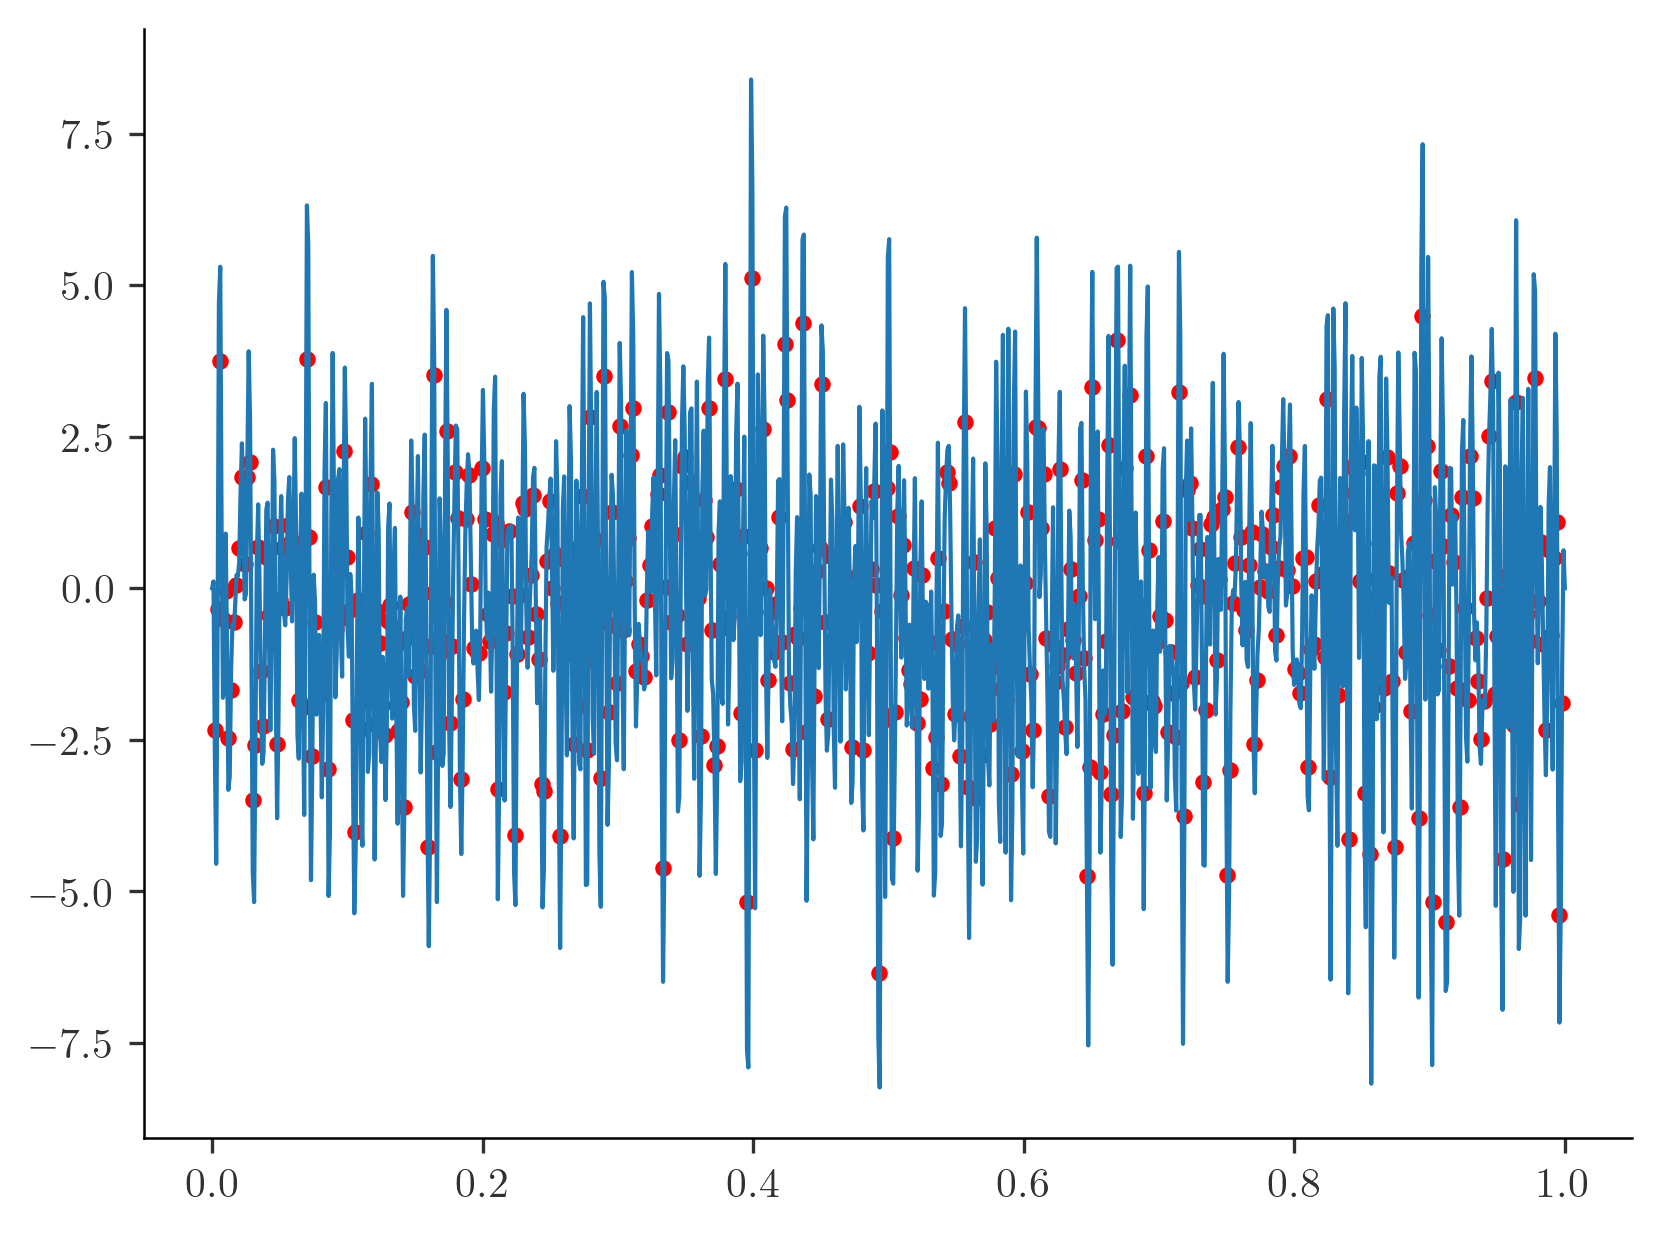

In [166]:
f_lambda = lambda x: evaluate_function(x, coef_f_linear, L=L) + b(x)*evaluate_function(x, coef_u, L) + tau(evaluate_function(x, coef_u, L))
f_quad = f_lambda(m_tool.root_psi)
f_meas = m_tool.project(f_quad)

plt.plot(x, f_values, label = r'$f(x)$')
plt.scatter(m_tool.centers, f_meas, color='r', s = 10, label = 'Measurements')
plt.show()

In [167]:
# First solve using the linear solver (for an initial guess)
reg = None
length_scale = 0.05


solver = kernel_linear_solver(length_scale, m_tool.psi_matrix, m_tool.root_psi, boundary, boundary_conditions, nu)
solver.solve_linear_prob(f_meas, reg, root_b, m_tool.L_stiff)

l_2_error, l_2_rel, h_s_error, h_s_rel = solver.compute_residuals_nl(f_meas, tau, root_b, m_tool.L_stiff)
loss, relative_loss = solver.compute_error(m_tool.x_error, m_tool.w_error, u_error)

pred = solver.evaluate_solution(x)

print("Residual relative L2 error: ", l_2_rel)
print("Residual relative Hs error: ", h_s_rel)

print("L2 error: ", loss)
print("L2 relative error: ", relative_loss)




Residual relative L2 error:  0.16175746160122165
Residual relative Hs error:  0.12357775417204883
L2 error:  0.06734761030353784
L2 relative error:  0.20219917931328313


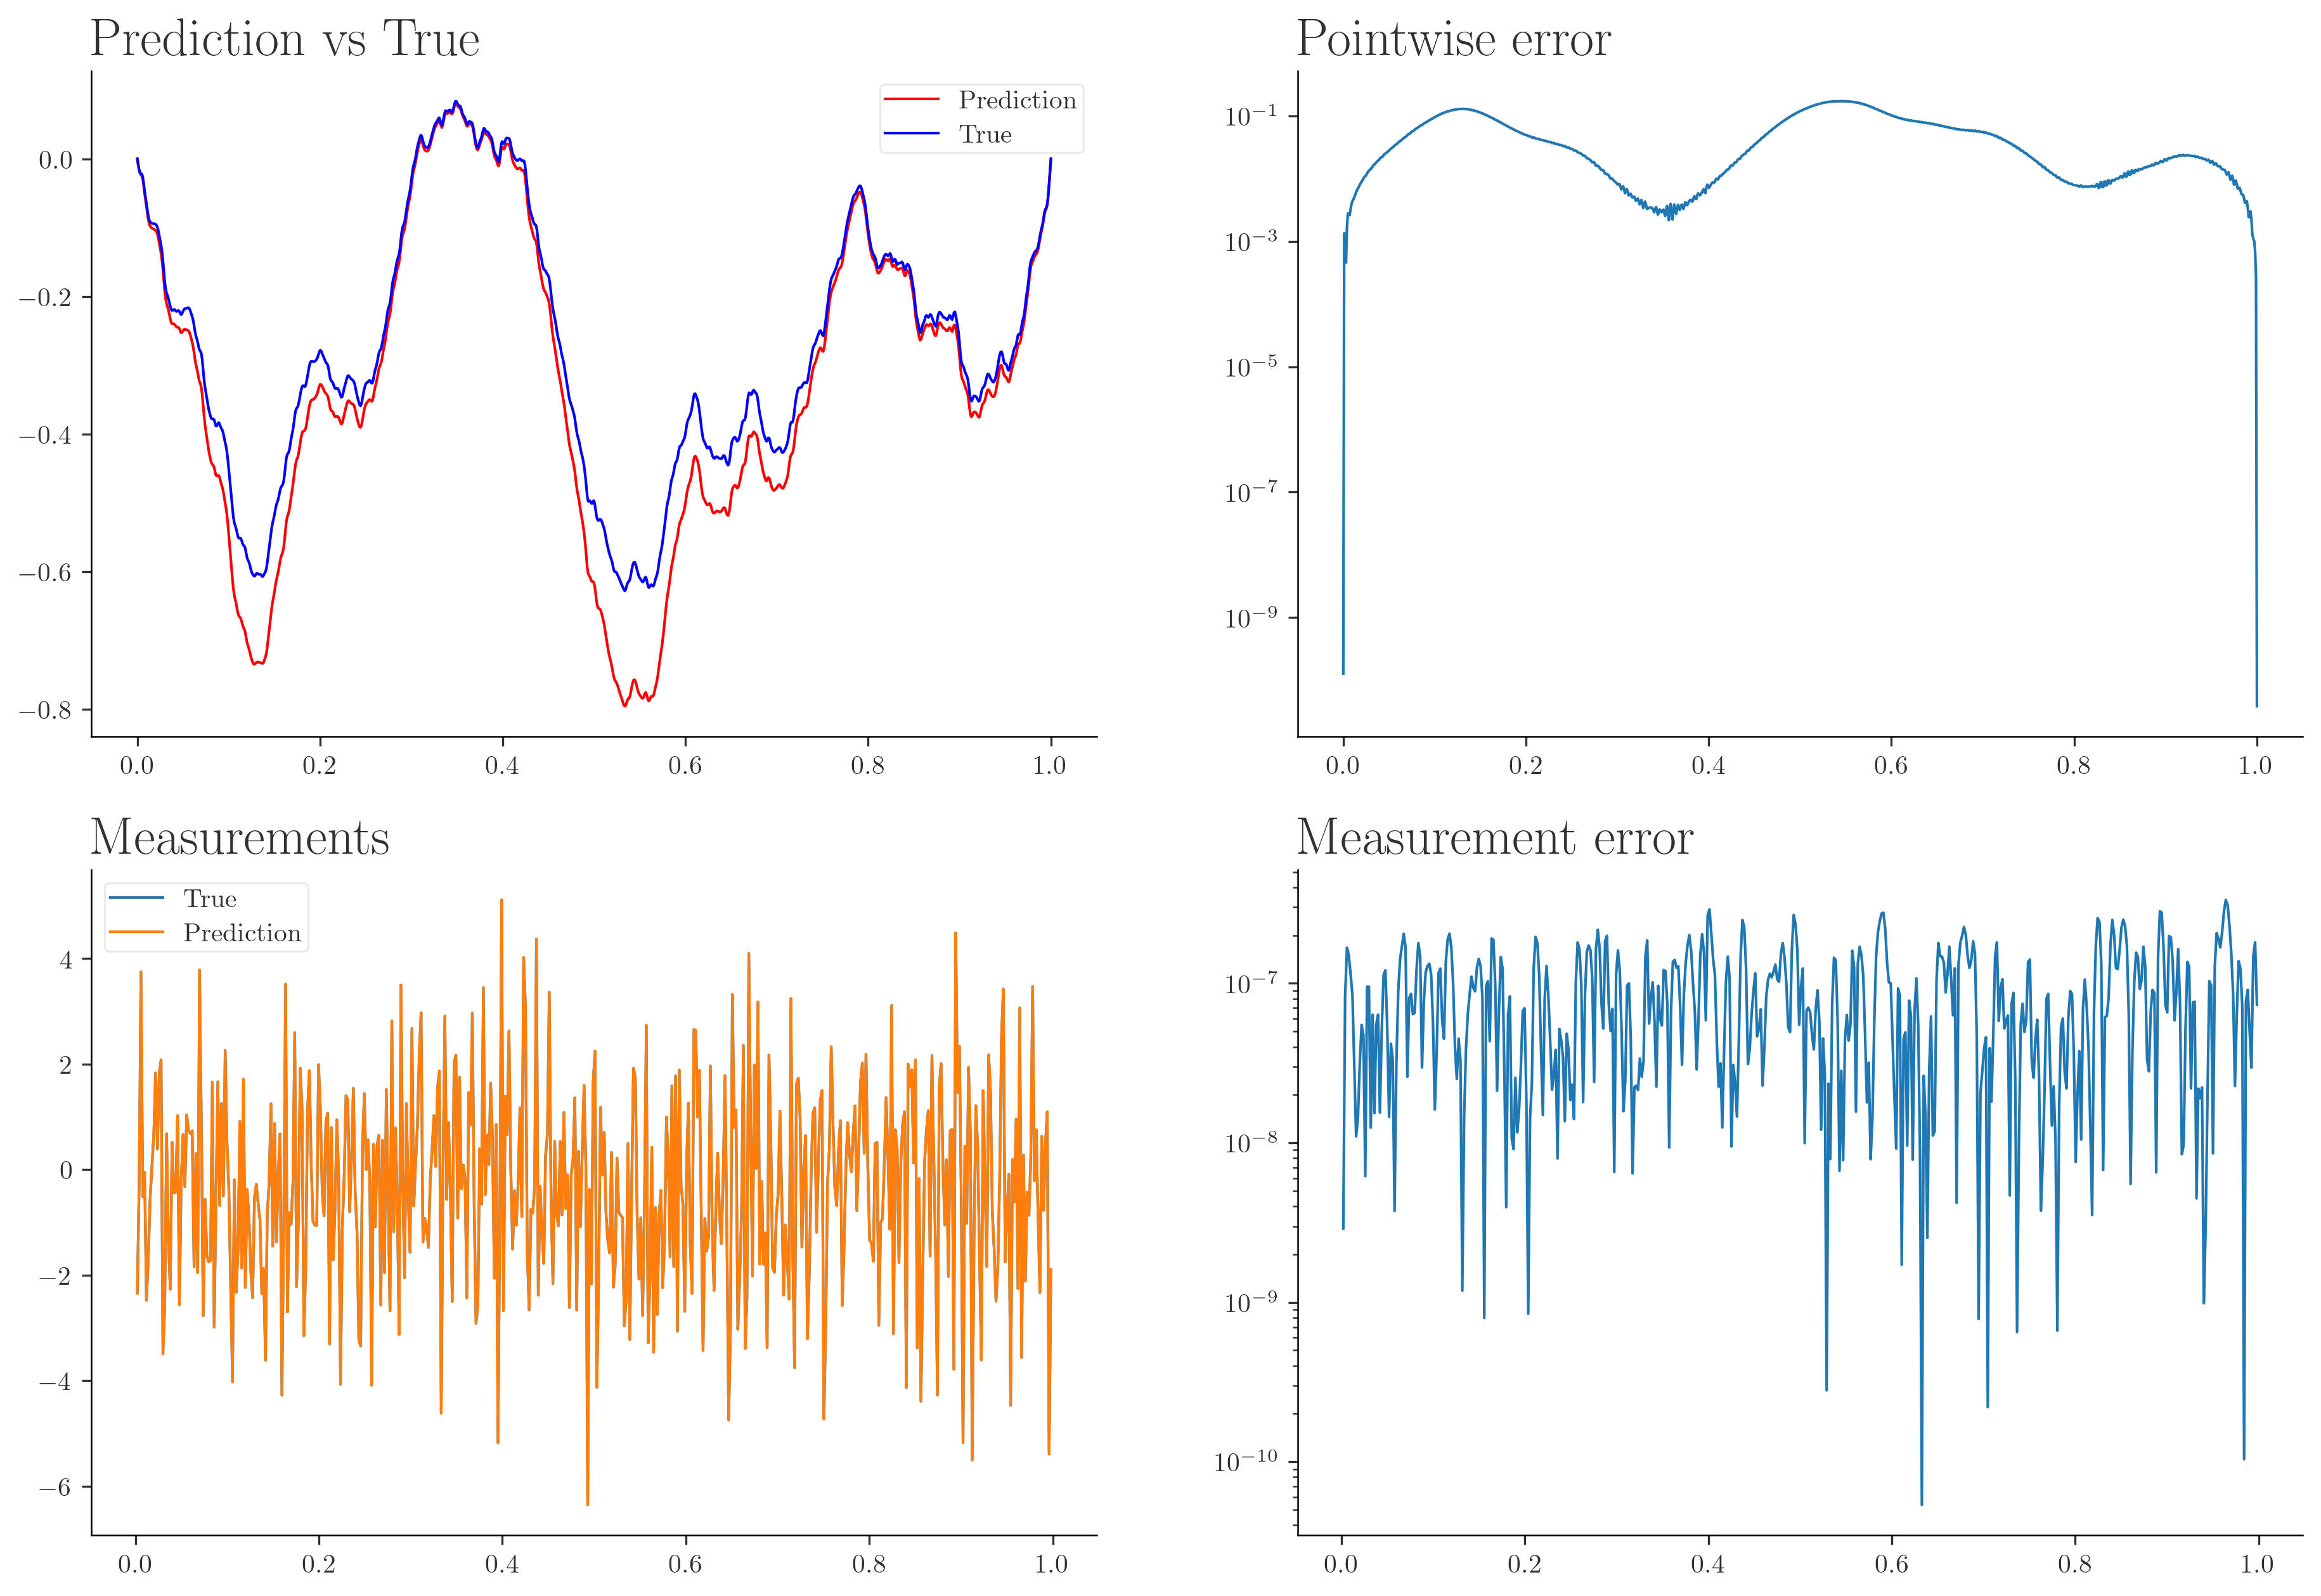

In [168]:
# Plot
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0,0].plot(x, pred, color = "tab:red", label = "Prediction")
ax[0,0].plot(x, u_values, color = "tab:blue", label = "True")
ax[0,0].set_title("Prediction vs True")
ax[0,0].legend()

ax[0,1].plot(x, jnp.abs(pred - u_values), label = "Error")
ax[0,1].set_title("Pointwise error")
ax[0,1].set_yscale('log')

ax[1,0].plot(m_tool.centers, f_meas, color = "tab:red", label = "True")
ax[1,0].plot(m_tool.centers, solver.meas,  color = "tab:blue", label = "Prediction")
ax[1,0].set_title("Measurements")
ax[1,0].legend()

ax[1,1].plot(m_tool.centers, jnp.abs(solver.meas - f_meas))
ax[1,1].set_title("Measurement error")
ax[1,1].set_yscale('log')

plt.show()

In [169]:
from utils_optim import Gauss_Newton_solver_variable, Gauss_Newton_solver

In [170]:
length_scale = 0.05
linear_solver = kernel_linear_solver(length_scale, m_tool.psi_matrix, m_tool.root_psi, boundary, boundary_conditions, nu)
reg = None


start = time.time()
solver_opt = Gauss_Newton_solver(m_tool.L_stiff, f_meas, b, tau, tau_prime, m_tool.psi_matrix, m_tool.root_psi, linear_solver, reg, n_iter = 50)
end = time.time()
print("Time to compute the solution: ", end - start)

l_2_error, l_2_rel, h_s_error, h_s_rel = solver_opt.compute_residuals_nl(f_meas, tau, root_b, m_tool.L_stiff)
loss, relative_loss = solver_opt.compute_error(m_tool.x_error, m_tool.w_error, u_error)

pred = solver_opt.evaluate_solution(x)

print("Residual relative L2 error: ", l_2_rel)
print("Residual relative Hs error: ", h_s_rel)

print("L2 error: ", loss)
print("L2 relative error: ", relative_loss)


Iteration 1, current error: 0.12358000000000001 H^-s, 0.16176000000000001 l_2. Improvement nan
Iteration 2, current error: 0.04034 H^-s, 0.05280000000000001 l_2. Improvement 0.67359
Iteration 3, current error: 0.032780000000000004 H^-s, 0.042910000000000004 l_2. Improvement 0.18724000000000002
Iteration 4, current error: 0.0327 H^-s, 0.042800000000000005 l_2. Improvement 0.0025900000000000003
Iteration 5, current error: 0.0327 H^-s, 0.042800000000000005 l_2. Improvement 0.0
Improvement too small, exiting
Time to compute the solution:  15.15364694595337
Residual relative L2 error:  0.04280009803264284
Residual relative Hs error:  0.03269944569317126
L2 error:  0.0004283833731191361
L2 relative error:  0.0012861446172440522


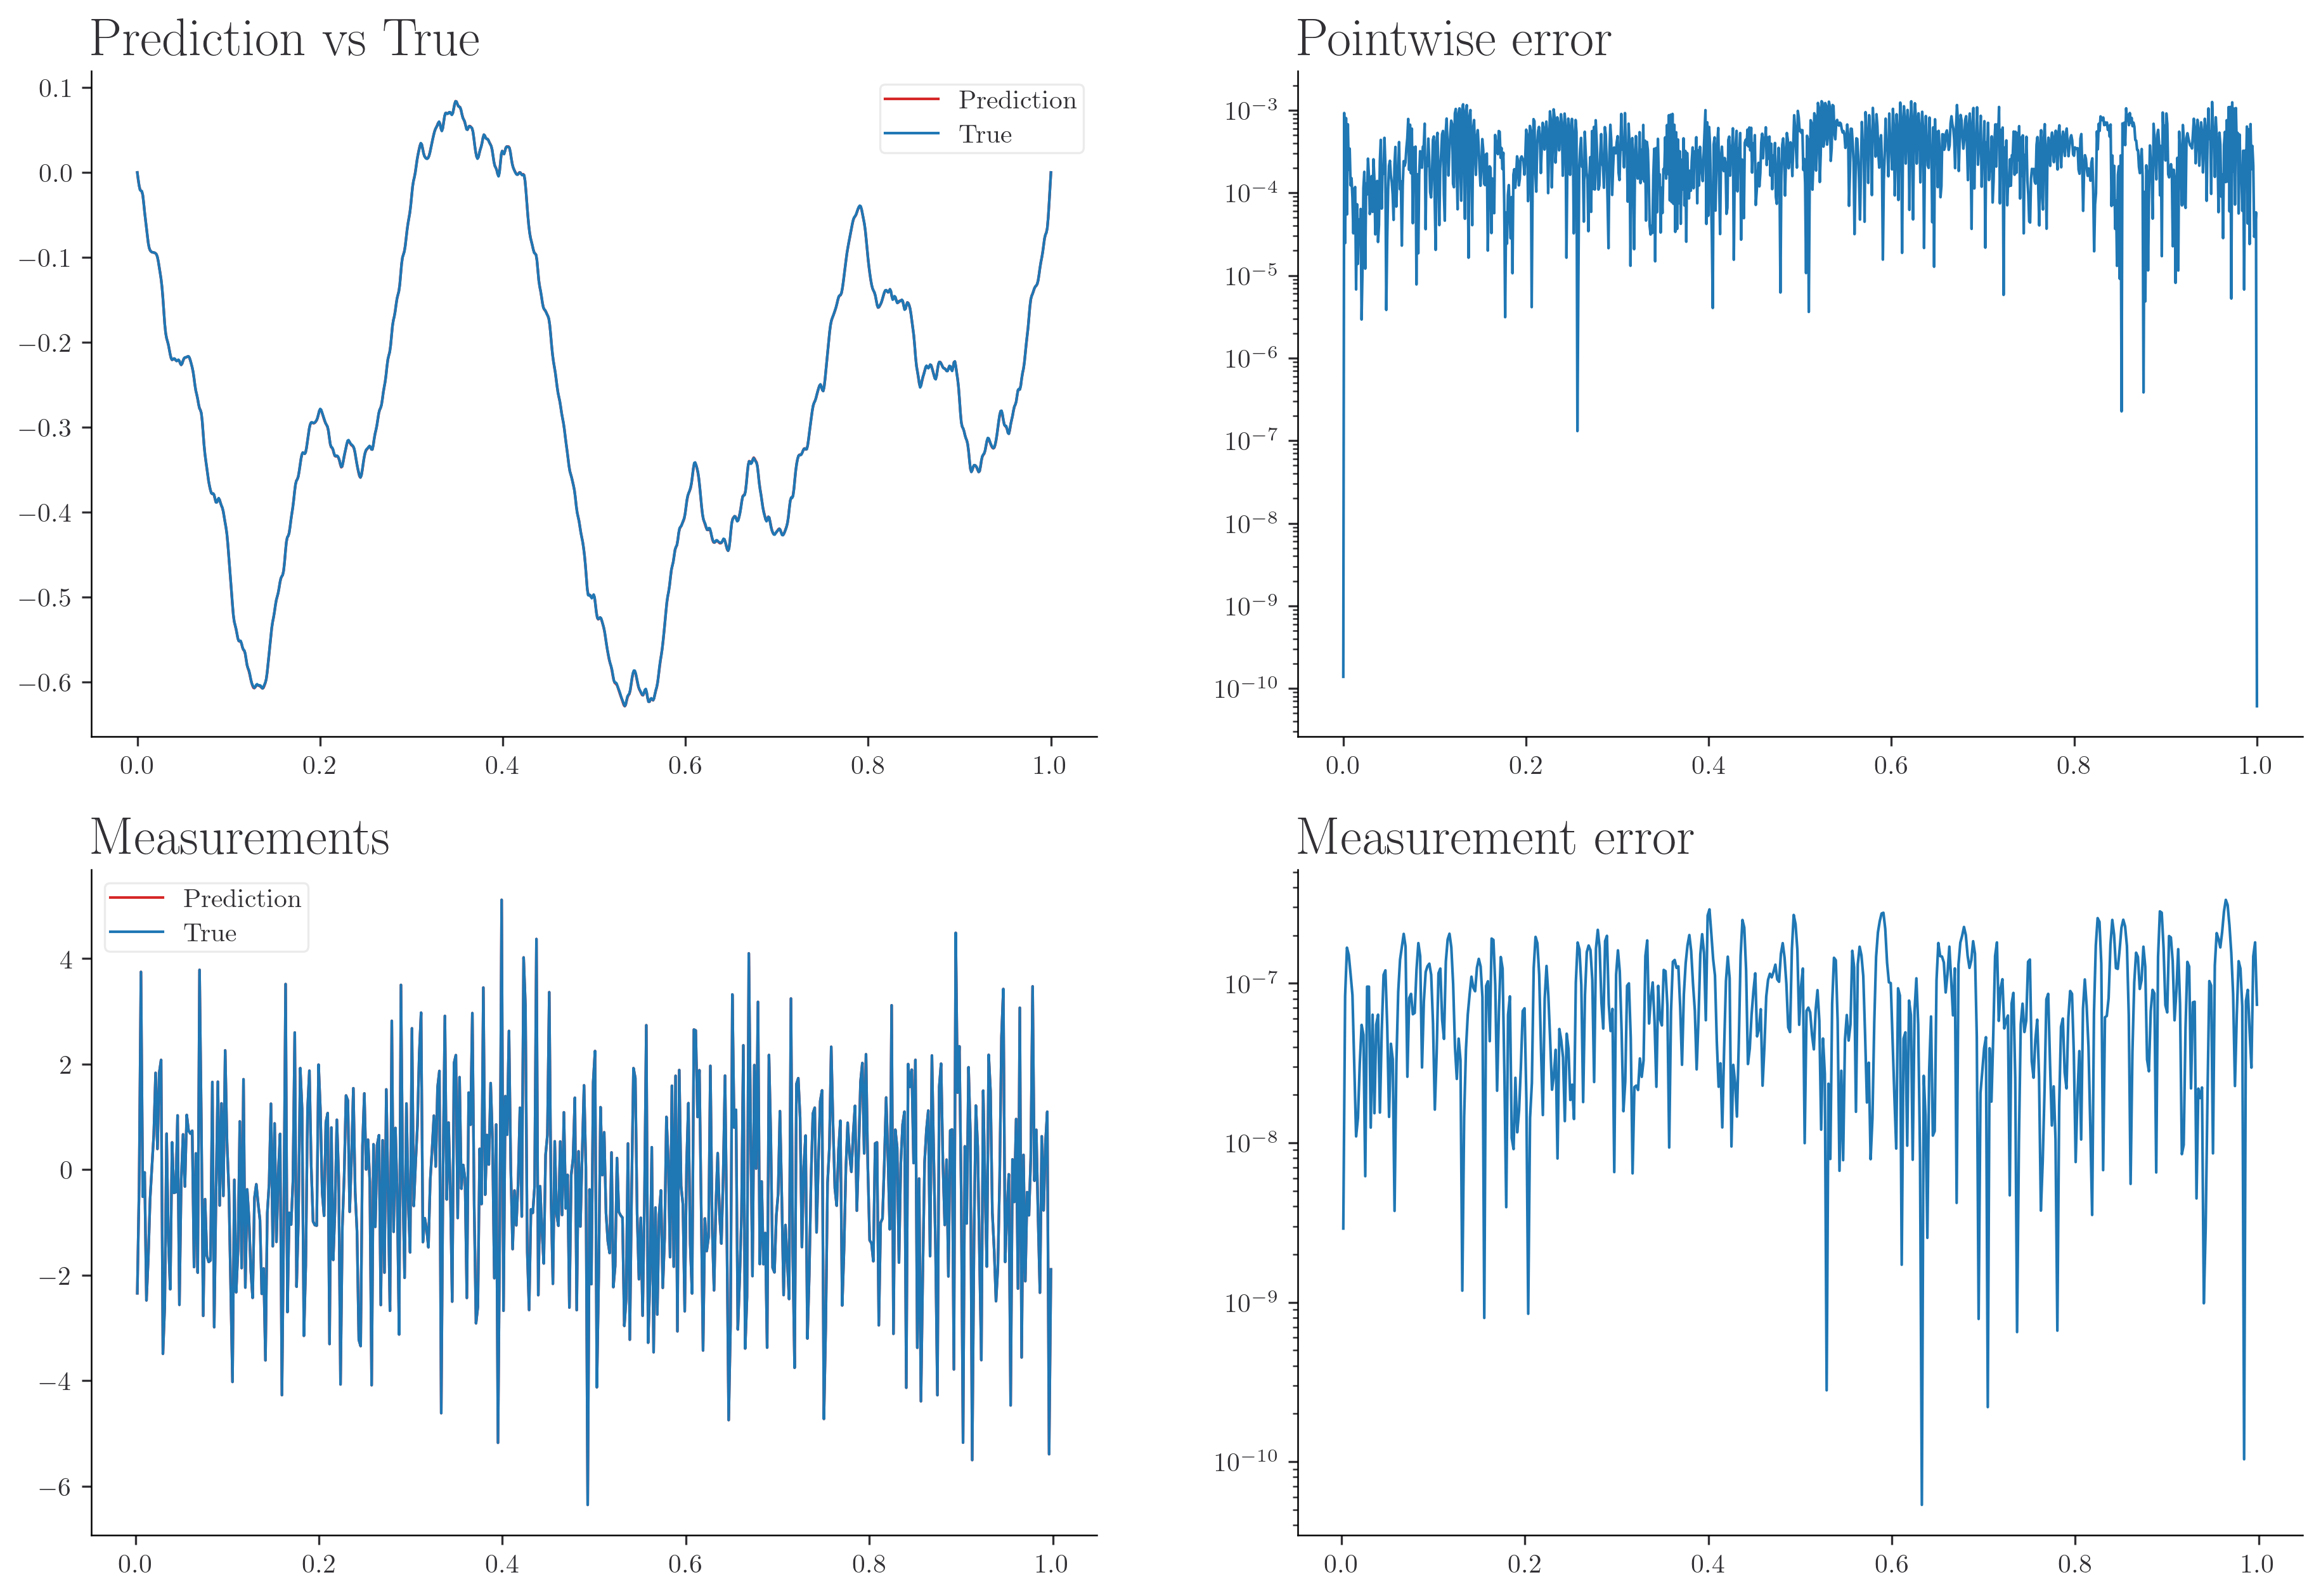

In [171]:
# Plot
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0,0].plot(x, pred, color = "tab:red", label = "Prediction")
ax[0,0].plot(x, u_values, color = "tab:blue", label = "True")
ax[0,0].set_title("Prediction vs True")
ax[0,0].legend()

ax[0,1].plot(x, jnp.abs(pred - u_values), label = "Error")
ax[0,1].set_title("Pointwise error")
ax[0,1].set_yscale('log')

ax[1,0].plot(m_tool.centers, solver.meas,  color = "tab:red", label = "Prediction")
ax[1,0].plot(m_tool.centers, f_meas, color = "tab:blue", label = "True")

ax[1,0].set_title("Measurements")
ax[1,0].legend()

ax[1,1].plot(m_tool.centers, jnp.abs(solver.meas - f_meas))
ax[1,1].set_title("Measurement error")
ax[1,1].set_yscale('log')

plt.show()

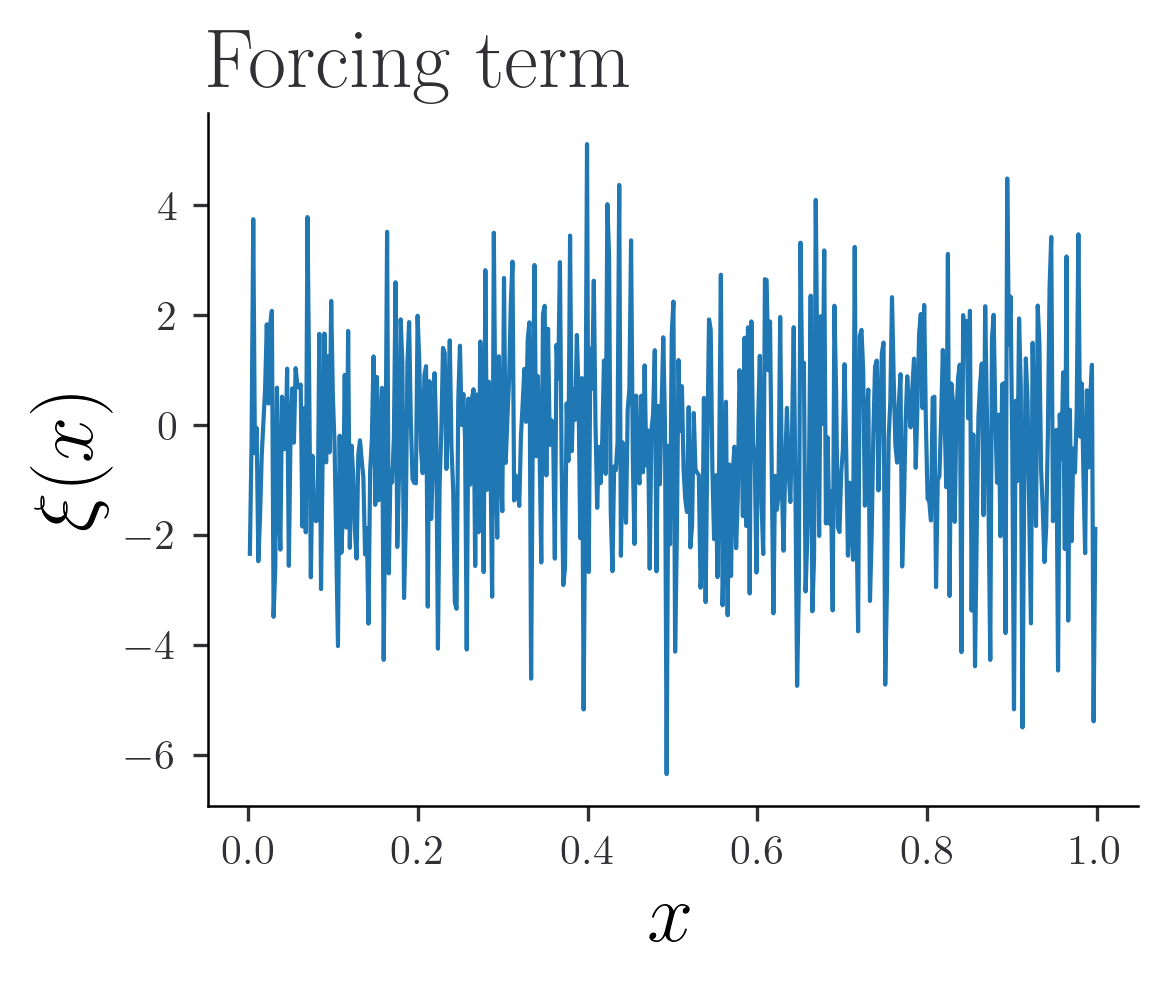

In [172]:
figure = plt.figure(figsize=(width, height))
plt.plot(m_tool.centers, f_meas, color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Forcing term")
plt.savefig('figures/semilinear_elliptic/forcing_term.png', bbox_inches = 'tight')
plt.show()


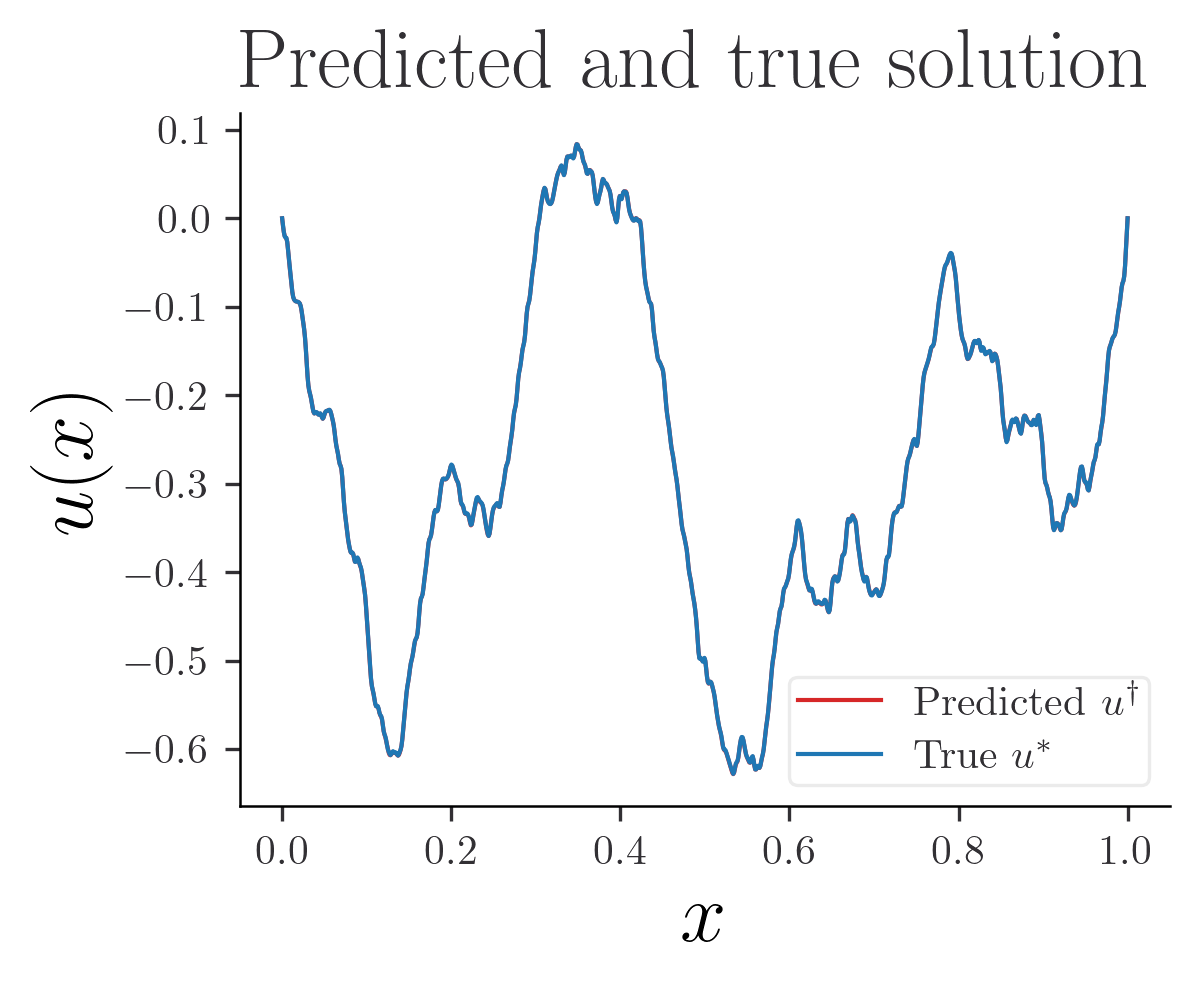

In [173]:
figure = plt.figure(figsize=(width, height))
plt.plot(x, pred, label = 'Predicted $u^\dagger$', color = 'tab:red')
plt.plot(x, u_values, label = r'True $u^*$', color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Predicted and true solution")
plt.legend()
plt.savefig('figures/semilinear_elliptic/prediction_solution_semilinear.png', bbox_inches = 'tight')
plt.show()


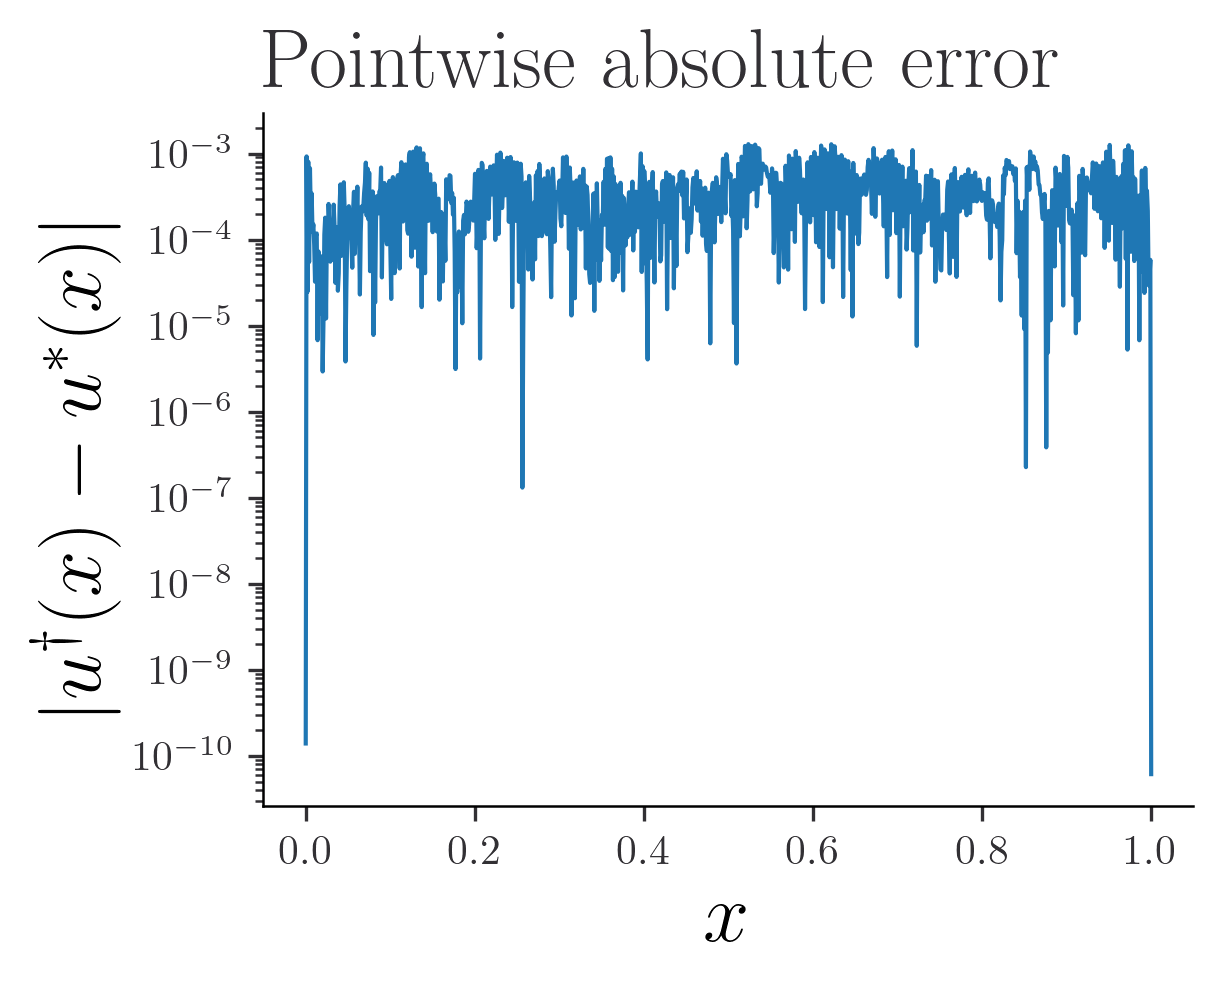

In [174]:
figure = plt.figure(figsize=(width, height))
plt.plot(x, jnp.abs(pred - u_values), color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.savefig('figures/semilinear_elliptic/pointwise_error.png', bbox_inches = 'tight')
plt.show()


# Computing error rates

In [175]:
meas_exp = jnp.arange(4, 11)
reg = None

error = []
error_rel = []
for i in tqdm(meas_exp):
    n_meas = 2**i
    m_tool = measurement_tool(domain, n_meas)
    root_b = m_tool.evaluate_at_roots(b)
    u_error = m_tool.evaluate_for_error(u_lambda)

    # Project f against the test functions
    f_quad = f_lambda(m_tool.root_psi)
    f_meas = m_tool.project(f_quad)

    # Solve the linear problem
    linear_solver = kernel_linear_solver(length_scale, m_tool.psi_matrix, m_tool.root_psi, boundary, boundary_conditions, nu)
    solver_opt = Gauss_Newton_solver(m_tool.L_stiff, f_meas, b, tau, tau_prime, m_tool.psi_matrix, m_tool.root_psi, linear_solver, reg, n_iter = 50, verbose = False)


    loss, relative_loss = solver_opt.compute_error(m_tool.x_error, m_tool.w_error, u_error)
    error.append(loss)
    error_rel.append(relative_loss)

100%|██████████| 7/7 [01:36<00:00, 13.84s/it]


In [176]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

k = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
l = log_error
r, C = jnp.linalg.lstsq(k, l)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

# # Plot the convergence rates 

# fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ax[0].plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
# ax[0].scatter(2**meas_exp, error)
# ax[0].set_yscale('log')
# ax[0].set_xscale('log')
# ax[0].set_xlabel("Number of measurements")
# ax[0].set_ylabel(r"$||u^\dagger - u^*||_{L^2}$")
# ax[0].set_title(r"Convergence of the $L^2$ error")
# ax[0].legend()

# ax[1].plot(2**meas_exp, error_rel, label = r"$r :{:.03f}$".format(r))
# ax[1].scatter(2**meas_exp, error_rel)
# ax[1].set_yscale('log')
# ax[1].set_xscale('log')
# ax[1].set_xlabel("Number of measurements")
# ax[1].set_title(r"Convergence of the relative $L^2$ error")
# ax[1].set_ylabel(r"$\frac{||u^\dagger - u^*||_{L^2}}{||u^*||_{L^2}}$")

# plt.show()

L^2 Convergence rate:  2.388


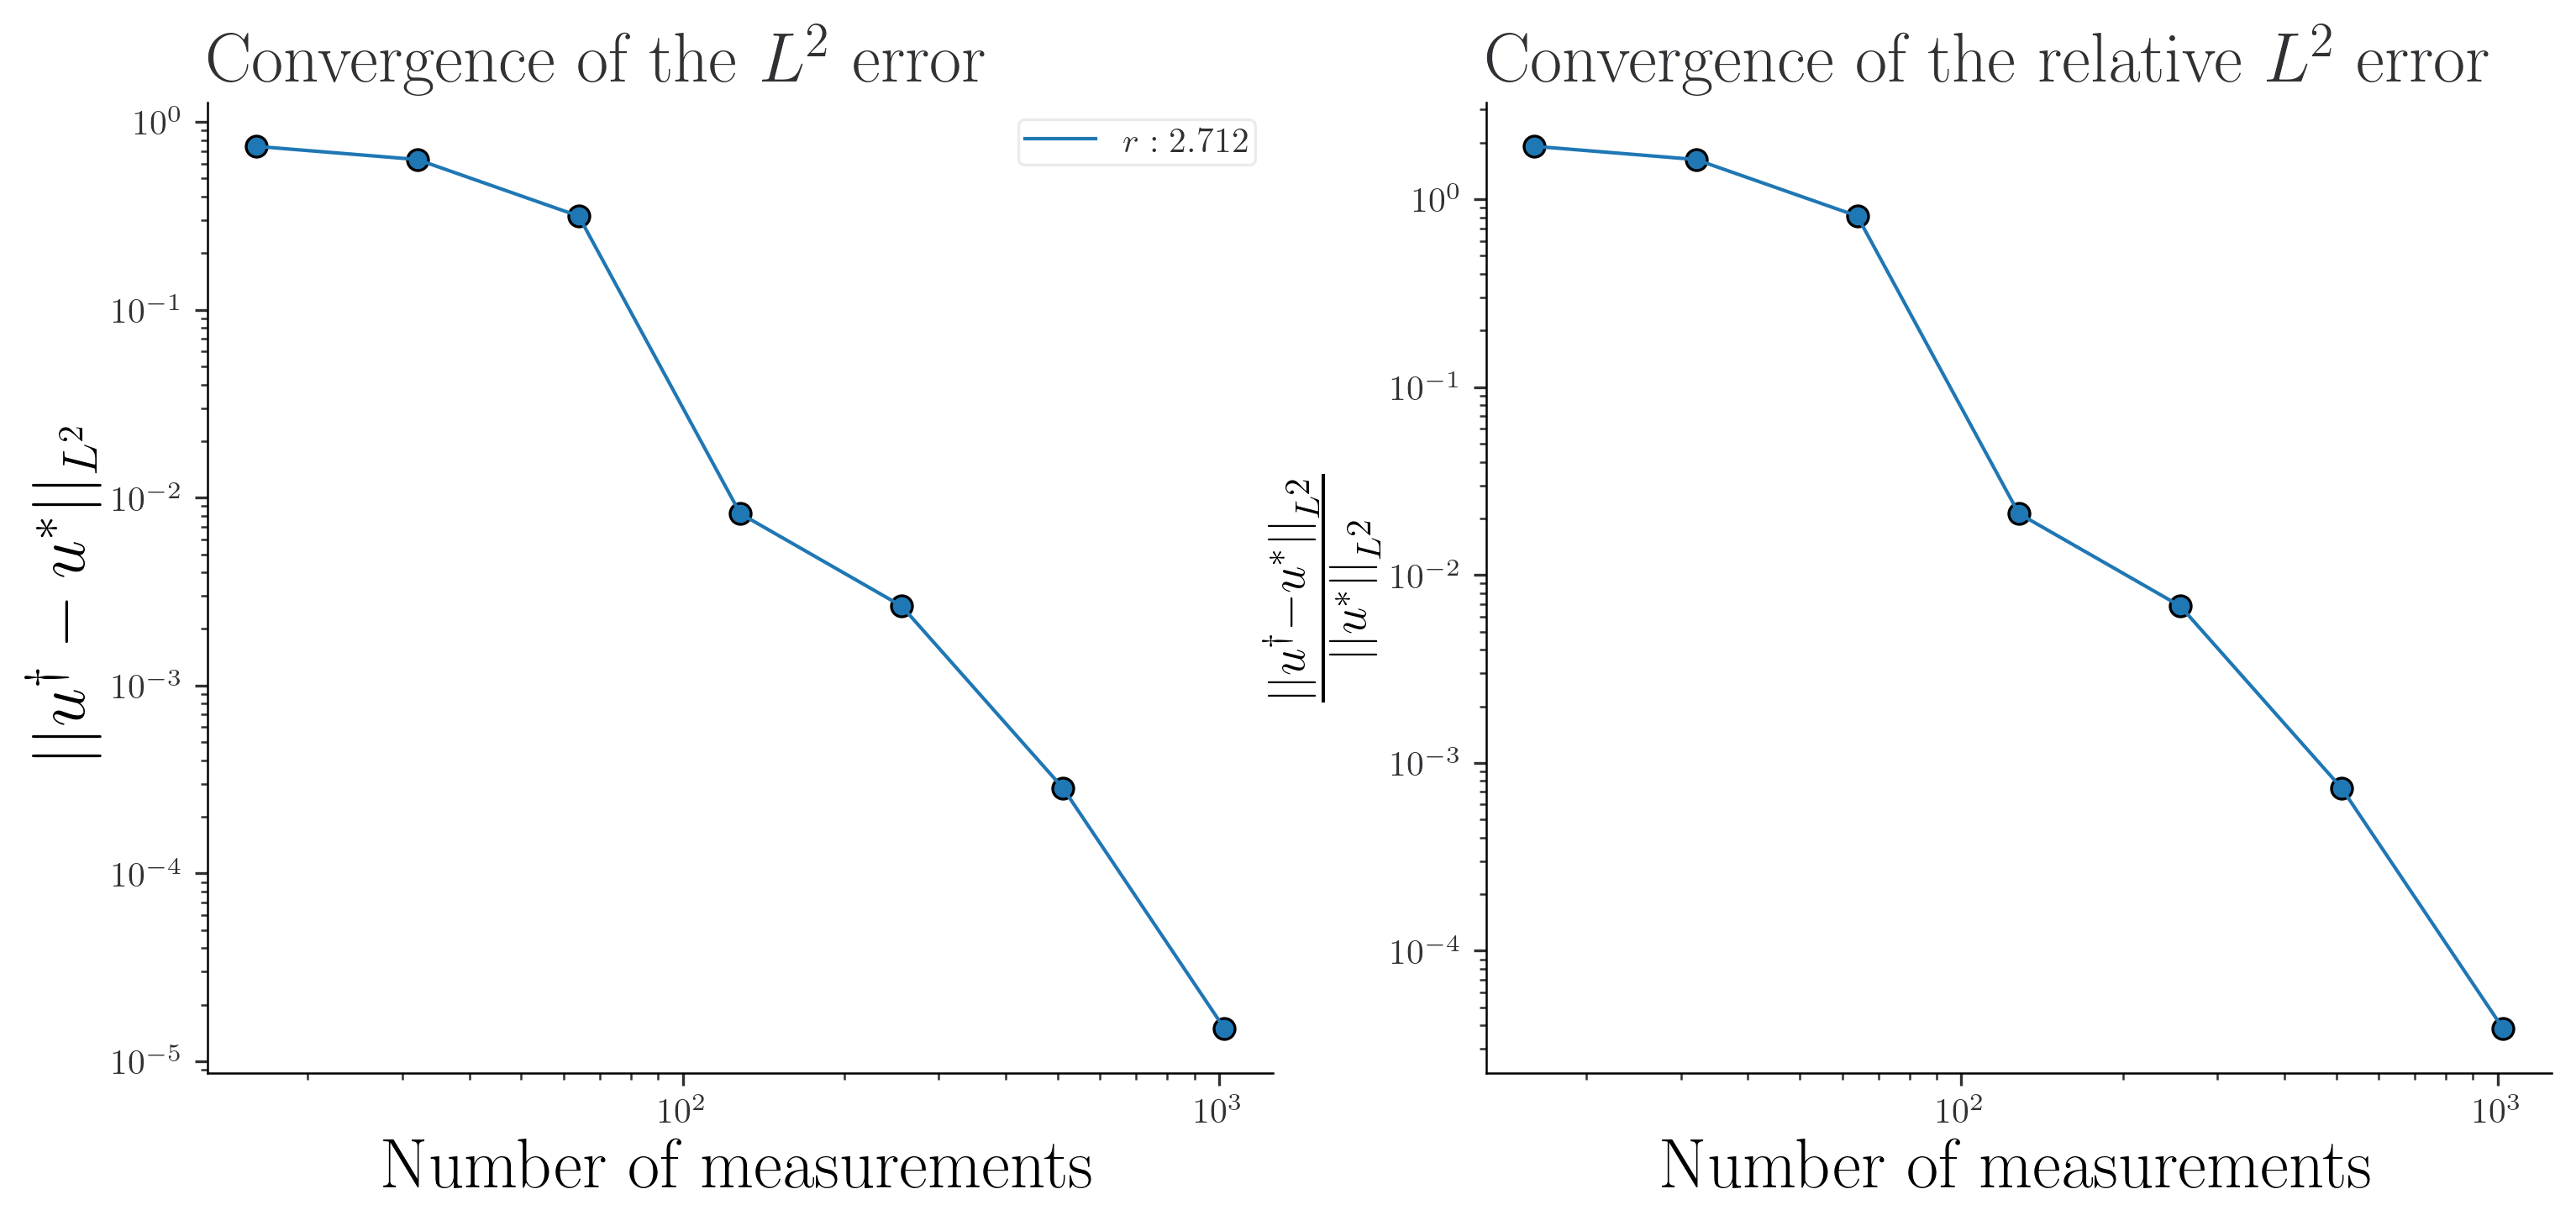

In [ ]:
# Plot the convergence rates 

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
ax[0].scatter(2**meas_exp, error)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("Number of measurements")
ax[0].set_ylabel(r"$||u^\dagger - u^*||_{L^2}$")
ax[0].set_title(r"Convergence of the $L^2$ error")
ax[0].legend()

ax[1].plot(2**meas_exp, error_rel, label = r"$r :{:.03f}$".format(r))
ax[1].scatter(2**meas_exp, error_rel)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("Number of measurements")
ax[1].set_title(r"Convergence of the relative $L^2$ error")
ax[1].set_ylabel(r"$\frac{||u^\dagger - u^*||_{L^2}}{||u^*||_{L^2}}$")

plt.show()

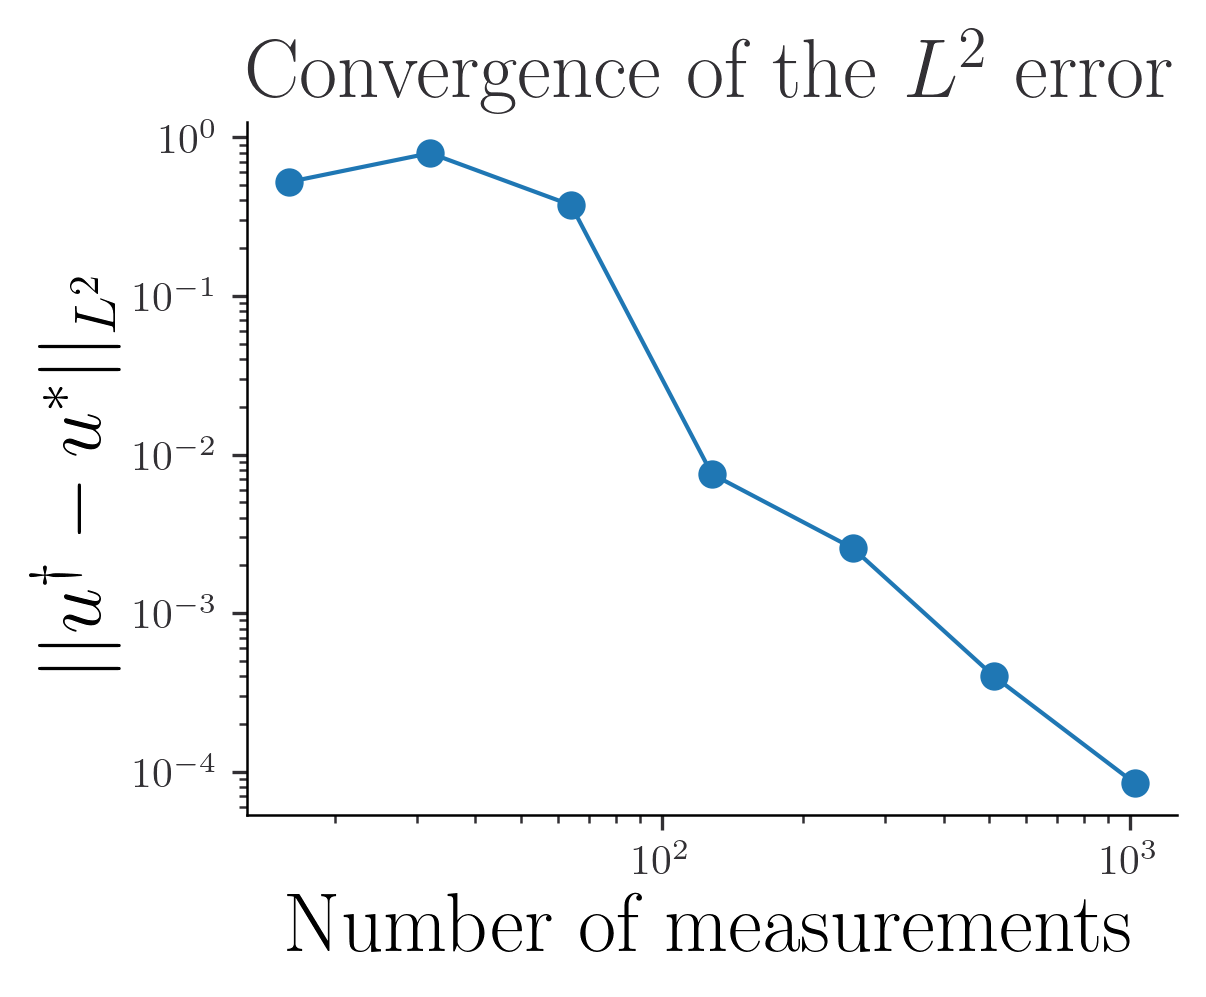

In [177]:
figure = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r), color = 'tab:blue')
plt.scatter(2**meas_exp, error, color = 'tab:blue')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.savefig('figures/semilinear_elliptic/error_rates.png', bbox_inches = 'tight')
plt.show()
